In this notebook we do the plots used in the publication.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform

from pathlib import Path

from gudhi import bottleneck_distance
from gudhi.hera.wasserstein import wasserstein_distance
import matplotlib.pyplot as plt

# if using dark mode
import matplotlib as mpl
# mpl.rcParams['figure.facecolor'] = 'white'
from matplotlib.ticker import MaxNLocator

from tqdm.notebook import tqdm
import time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler

from grammodels.representations import Treegrams, Cliquegram, Facegram,\
    format_mergegram, compare_mergegrams
from grammodels.simplexdiagram import CriticalSimplexDiagram

from grammodels.facegram import facegram_alg1, facegram_alg2
from grammodels.create_data import create_random_similar_trees

In [2]:
csfont = {'fontname': 'Helvetica'}
hfont = {'fontname': 'Helvetica'}

In [3]:
def sort_dict_by_entries(mydict):
    sorted_dict = dict(sorted(mydict.items(), key=lambda item: (item[1][0], item[1][1], item[0])))
    return sorted_dict

def plot_mergegram_scatter(mergegrams, ax=None, **kwargs):
    if not isinstance(mergegrams, list) and\
       not (isinstance(mergegrams, np.ndarray) and mergegrams.ndim == 3):
        mergegrams = [mergegrams]
    
    
    if ax is None:
        fig, ax = plt.subplots(1, len(mergegrams), dpi=200)
    else:
        fig = plt.gcf()
    
    pts_list = []
    color_list = []
    for axi, mergegram in enumerate(mergegrams):
        xy = np.array([[mgm[0], mgm[1]] for mgm in mergegram if mgm[1]!=np.inf])
        unique_elts, counts = np.unique(xy, axis=0, return_counts=True)

        pts_list.append(unique_elts)
        color_list.append(counts)

    vmin = 1
    vmax = np.max(np.hstack(color_list))

    ax_limits = np.vstack(pts_list)
    ax_limits = [np.min(ax_limits[:, 0]), np.max(ax_limits[:, 0]),
                 np.min(ax_limits[:, 1]), np.max(ax_limits[:, 1])]

    for axi, mergegram in enumerate(mergegrams):
        im = ax[axi].scatter(pts_list[axi][:,0],
                             pts_list[axi][:,1],
                             c=color_list[axi],
                             vmin=1, vmax=vmax,
                             **kwargs)
        
        fig.colorbar(im, ax=ax[axi],
                     ticks=MaxNLocator(integer=True))

    return(fig, ax, ax_limits)

# Dataset 1: Same cliquegram / facegram

In [4]:
treedistance1 = np.array([
    [0, 2, 3, 3, 3],
    [2, 0, 3, 3, 3],
    [3, 3, 0, 1, 3],
    [3, 3, 1, 0, 3],
    [3, 3, 3, 3, 0]
])
treedistance2 = np.array([
    [0, 4, 1, 4, 4],
    [4, 0, 4, 3, 1],
    [1, 4, 0, 4, 4],
    [4, 3, 4, 0, 3],
    [4, 1, 4, 3, 0]
])

treedistances = [treedistance1, treedistance2]
treegrams_cl = Treegrams(treedistances=treedistances)
mgm_trees = treegrams_cl.compute_labelled_mergegram()

treegrams = [sort_dict_by_entries(td) for td in treegrams_cl.treegramslist]

here

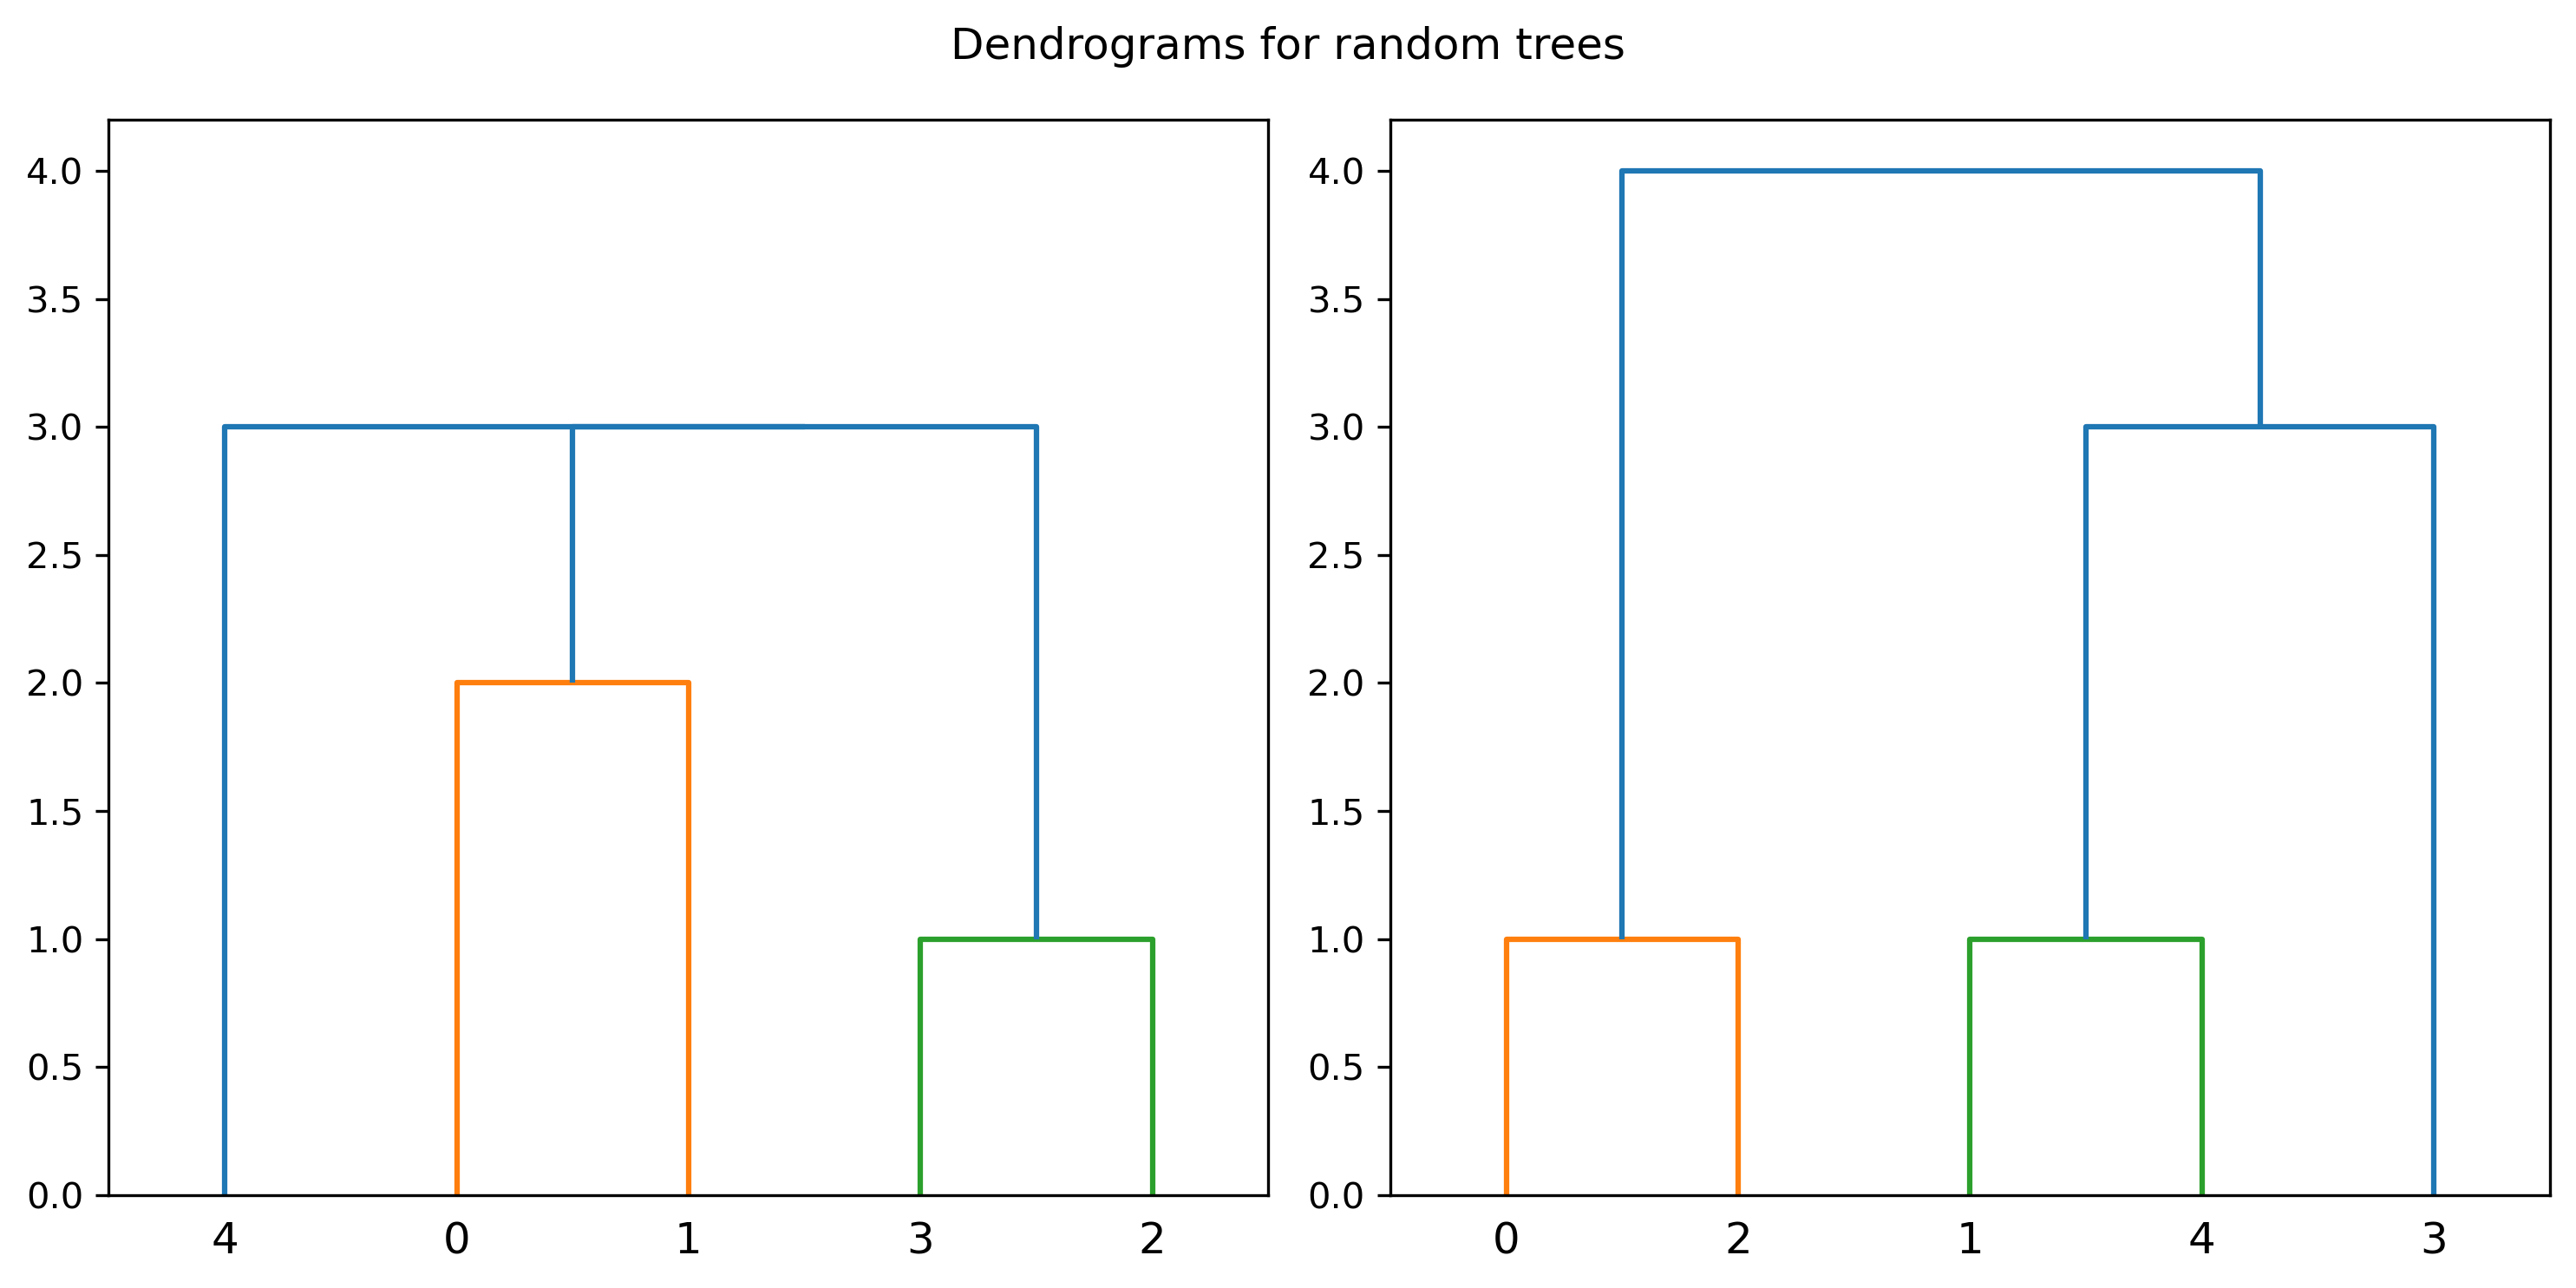

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

Z = sch.linkage(squareform(treedistance1), method='single', optimal_ordering=True)
sch.dendrogram(Z, ax=ax[0])

Z = sch.linkage(squareform(treedistance2), method='single', optimal_ordering=True)
sch.dendrogram(Z, ax=ax[1])

ax[0].set_ylim(0, 4.2)
ax[1].set_ylim(0, 4.2)

fig.suptitle('Dendrograms for random trees')
fig.tight_layout()

fig.savefig(Path('plots', 'dataset1_dendrograms.png'), dpi=300, bbox_inches='tight')

In [8]:
treegrams_cl.treegramslist

[{(2,): [0, 1.0],
  (3,): [0, 1.0],
  (0,): [0, 2.0],
  (1,): [0, 2.0],
  (4,): [0, 3.0],
  (2, 3): [1.0, 3.0],
  (0, 1): [2.0, 3.0],
  (0, 1, 2, 3, 4): [3.0, inf]},
 {(0,): [0, 1.0],
  (2,): [0, 1.0],
  (1,): [0, 1.0],
  (4,): [0, 1.0],
  (3,): [0, 3.0],
  (1, 4): [1.0, 3.0],
  (0, 2): [1.0, 4.0],
  (1, 3, 4): [3.0, 4.0],
  (0, 1, 2, 3, 4): [4.0, inf]}]

In [9]:
mgm_tree1 = format_mergegram(mgm_trees[0], delete_infinite=True)
mgm_tree2 = format_mergegram(mgm_trees[1], delete_infinite=True)

cliquegram = Cliquegram()
cliquegram.minimizer_from_treegrams(treegrams_cl.treedistances)
mgm_clique = cliquegram.compute_mergegram()
mgm_clique = format_mergegram(mgm_clique, delete_infinite=True)

facegram = Facegram(treegrams=treegrams_cl)
mgm_face = facegram.compute_join()
mgm_face = format_mergegram(mgm_face, delete_infinite=True)

print("cliquegram and facegram the same?", np.all(mgm_clique == mgm_face))

cliquegram and facegram the same? True


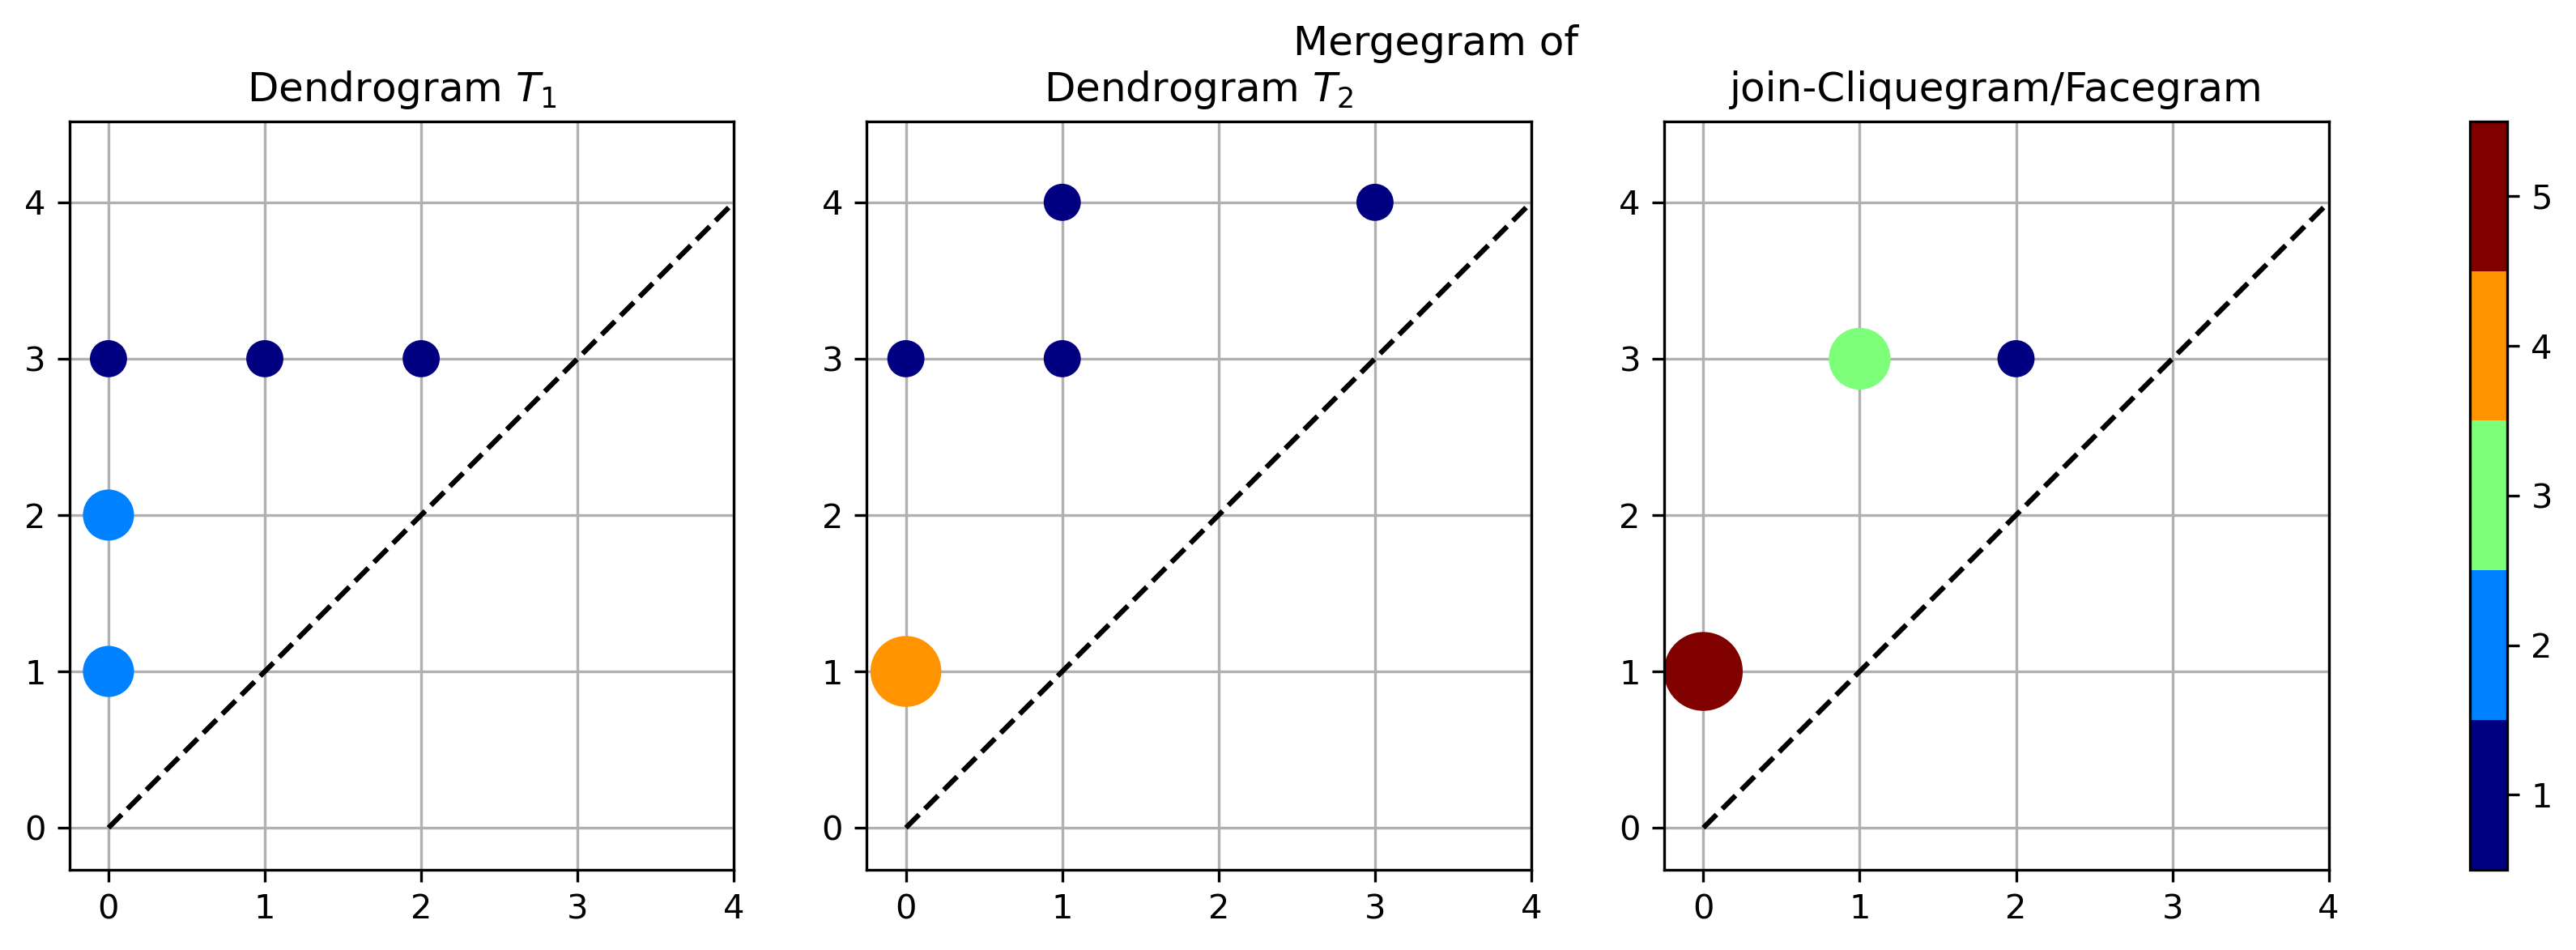

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=300)

for i, mgm in enumerate([mgm_tree1, mgm_tree2, mgm_face]):
    points, counts = np.unique(mgm, return_counts=True, axis=0)
    im = ax[i].scatter(points[:,0], points[:,1], s=counts*100,
                       c=counts, cmap='jet', vmin=1, vmax=5)

    cmap = plt.cm.jet  
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (.5, .5, .5, 1.0)
    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
    # define the bins and normalize
    bounds = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for i in range(3):
    ax[i].plot([0, 4], [0, 4], 'k--')
    ax[i].axis('equal')
    # ax[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    # ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i].set_xlim(-0.25, 4)
    ax[i].set_ylim(0, 4.25)
    ax[i].set_xticks([0, 1, 2, 3, 4])
    ax[i].set_yticks([0, 1, 2, 3, 4])

    ax[i].set_axisbelow(True)
    ax[i].grid(True)

ax[0].set_title('Dendrogram $T_1$')
ax[1].set_title('Dendrogram $T_2$')
ax[2].set_title('join-Cliquegram/Facegram')
fig.suptitle('Mergegram of')

fig.colorbar(im, ax=ax.ravel().tolist(),
        cmap=cmap, norm=norm,
        ticks=MaxNLocator(integer=True),
        boundaries=bounds, format='%1i')
fig.savefig(Path('plots', 'dataset1_Mergegrams_for_random_trees.png'), dpi=300, bbox_inches='tight')

# Dataset 2: three different dendrograms for a specific dataset (example)

In [11]:
treedistances = []

dist = np.array([[0,1,2], [0,0,2], [0,0,0]])
dist += np.transpose(dist)
treedistances.append(dist)

dist = np.array([[0,2,1], [0,0,2], [0,0,0]])
dist += np.transpose(dist)
treedistances.append(dist)

dist = np.array([[0,2,2], [0,0,1], [0,0,0]])
dist += np.transpose(dist)
treedistances.append(dist)

treegrams = Treegrams(treedistances=treedistances)
mgm_trees = treegrams.compute_labelled_mergegram()

cliquegram = Cliquegram()
cliquegram.minimizer_from_treegrams(treegrams.treedistances)
mgm_clique = cliquegram.compute_mergegram()

facegram = Facegram(treegrams=treegrams)
mgm_face = facegram.compute_join()

mgm_tree1 = format_mergegram(mgm_trees[0], delete_infinite=True)
mgm_tree2 = format_mergegram(mgm_trees[1], delete_infinite=True)
mgm_tree3 = format_mergegram(mgm_trees[2], delete_infinite=True)

mgm_clique = format_mergegram(mgm_clique, delete_infinite=True)
mgm_face = format_mergegram(mgm_face, delete_infinite=True)




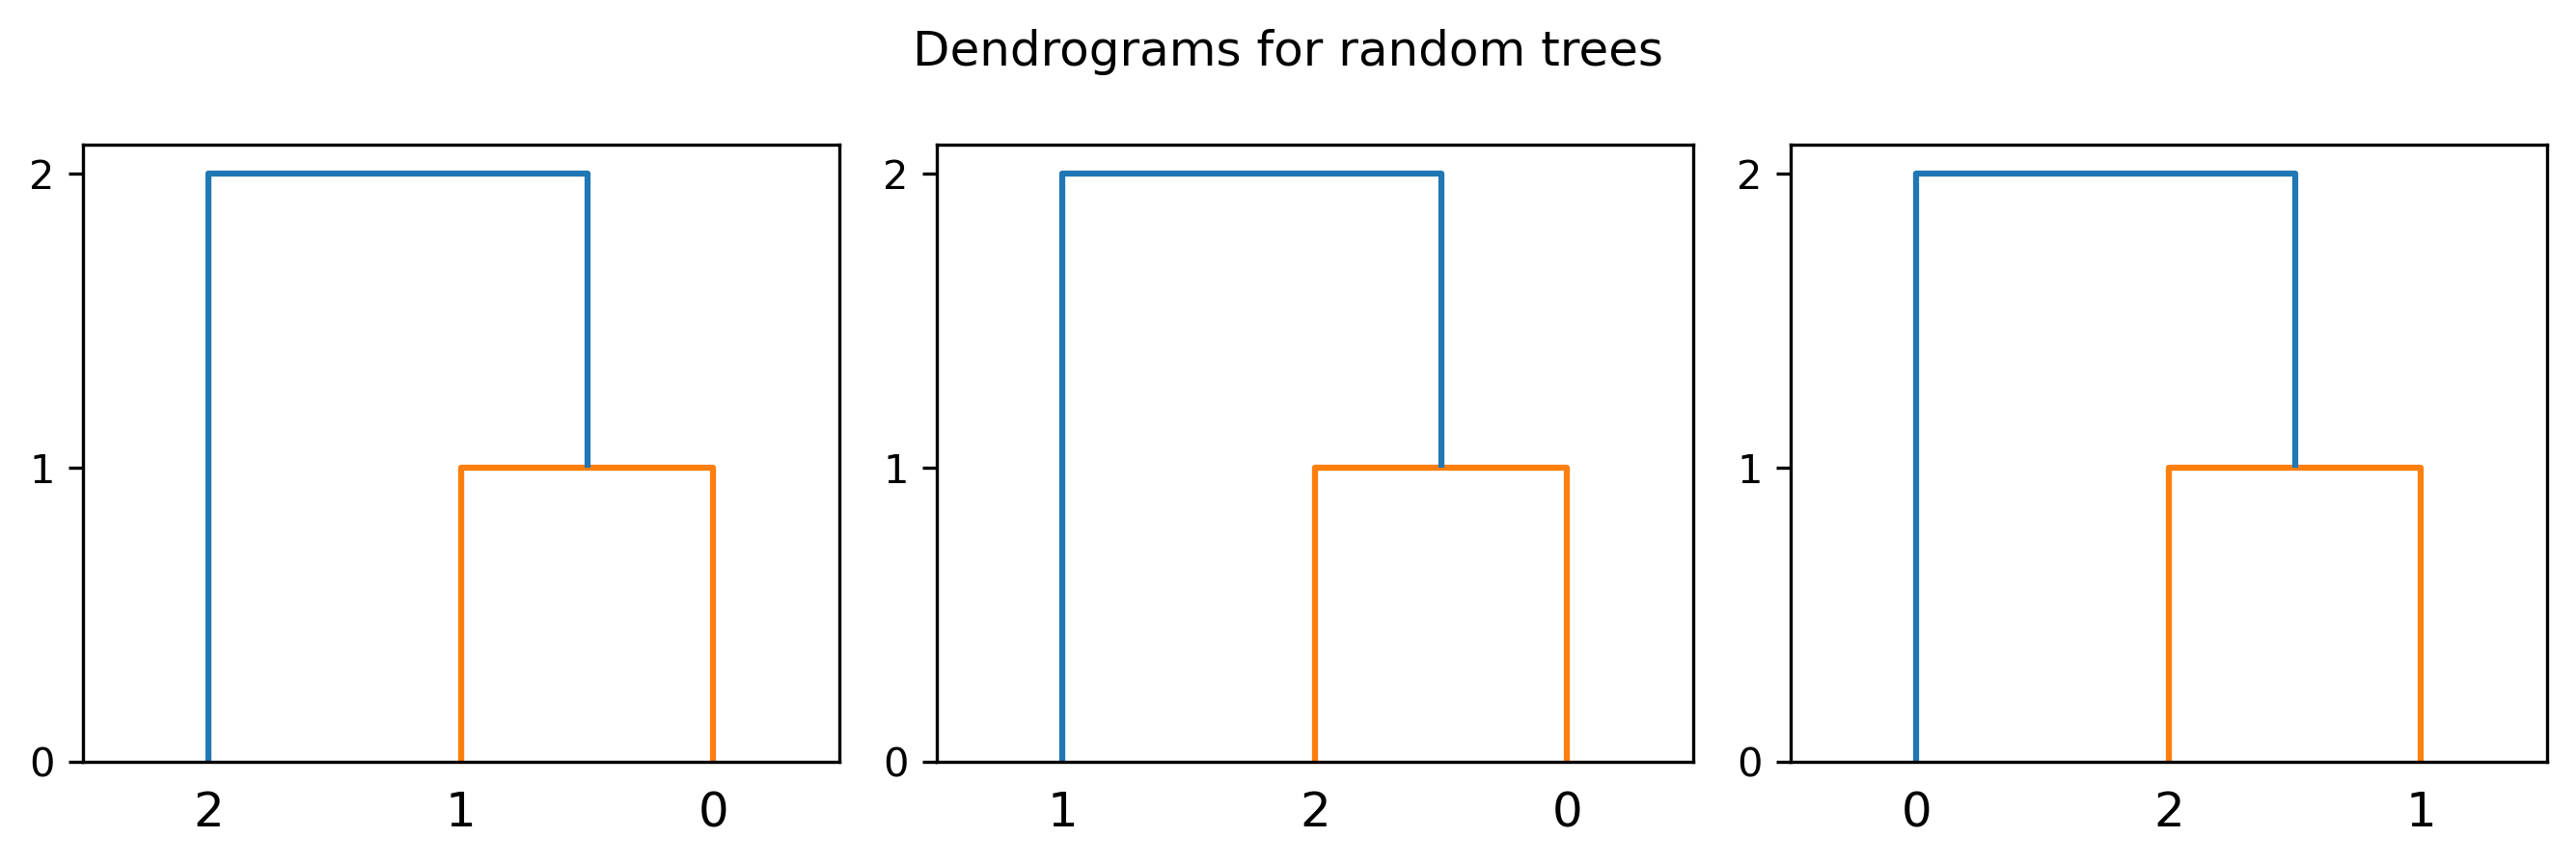

In [12]:
dendrograms = [sch.linkage(squareform(np.squeeze(td)),
              method='complete',
              metric='euclidean',
              optimal_ordering=True)
              for td in treedistances]

fig, ax = plt.subplots(1,3, figsize=(9,3), dpi=300)
for i in range(3):
    sch.dendrogram(dendrograms[i], ax=ax[i])
    ax[i].set_yticks([0, 1, 2])
fig.suptitle('Dendrograms for random trees')
fig.tight_layout()
fig.savefig(Path('plots', 'dataset2_Dendrograms_3.png'), dpi=300, bbox_inches='tight')

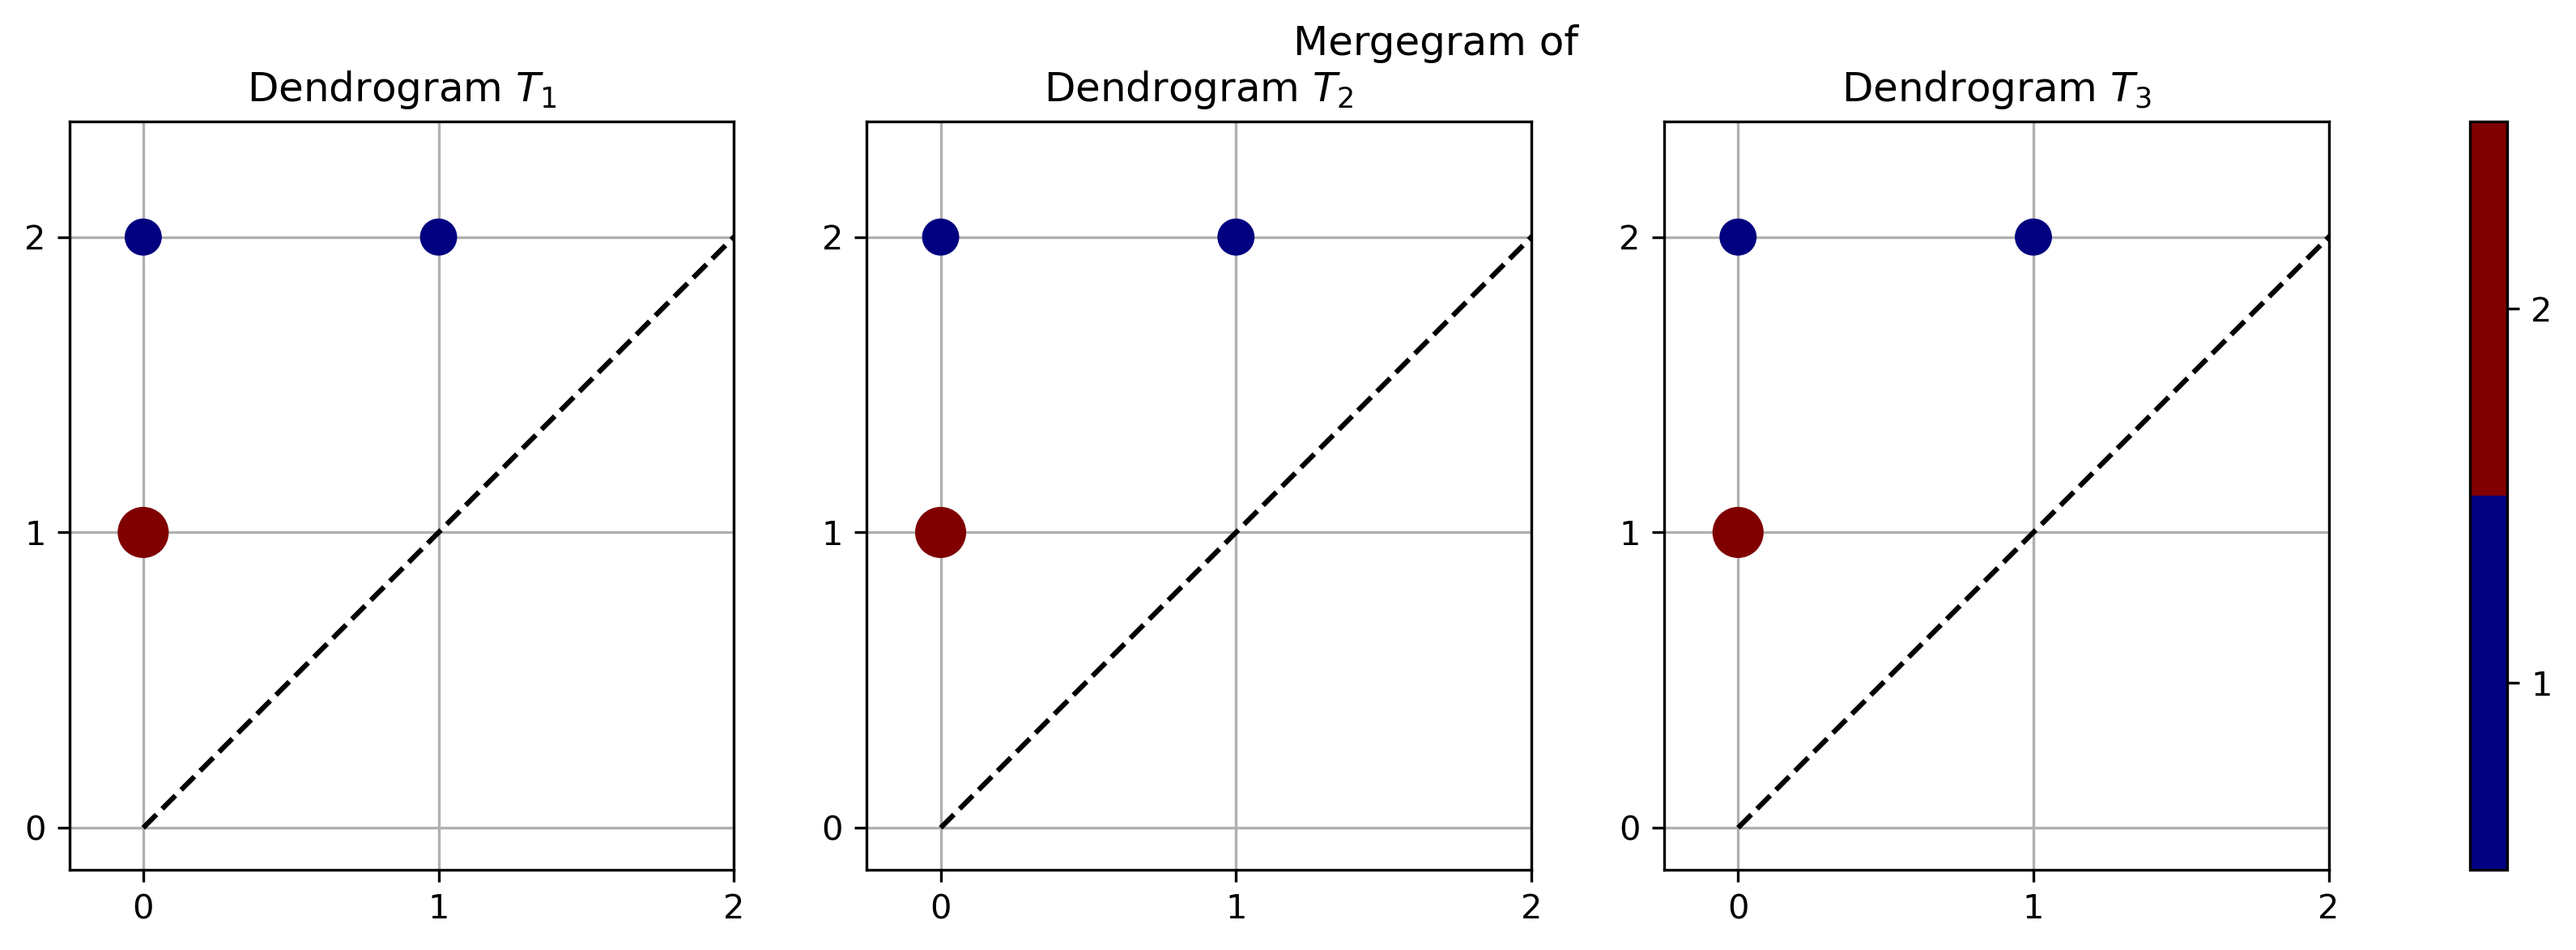

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=300)

for i, mgm in enumerate([mgm_tree1, mgm_tree2, mgm_tree3]):
    points, counts = np.unique(mgm, return_counts=True, axis=0)
    im = ax[i].scatter(points[:,0], points[:,1], s=counts*100,
                       c=counts, cmap='jet', vmin=1, vmax=2)

    cmap = plt.cm.jet  
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (.5, .5, .5, 1.0)
    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
    # define the bins and normalize
    bounds = [0.5, 1.5, 2.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for i in range(3):
    ax[i].plot([0, 4], [0, 4], 'k--')
    ax[i].axis('equal')
    # ax[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    # ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i].set_xlim(-0.25, 2)
    ax[i].set_ylim(0, 2.25)
    ax[i].set_xticks([0, 1, 2])
    ax[i].set_yticks([0, 1, 2])

    ax[i].set_axisbelow(True)
    ax[i].grid(True)

ax[0].set_title('Dendrogram $T_1$')
ax[1].set_title('Dendrogram $T_2$')
ax[2].set_title('Dendrogram $T_3$')
fig.suptitle('Mergegram of')

fig.colorbar(im, ax=ax.ravel().tolist(),
        cmap=cmap, norm=norm,
        ticks=MaxNLocator(integer=True),
        boundaries=bounds, format='%1i')
fig.savefig(Path('plots', 'dataset2_Mergegrams_for_dendrograms.png'), dpi=300, bbox_inches='tight')

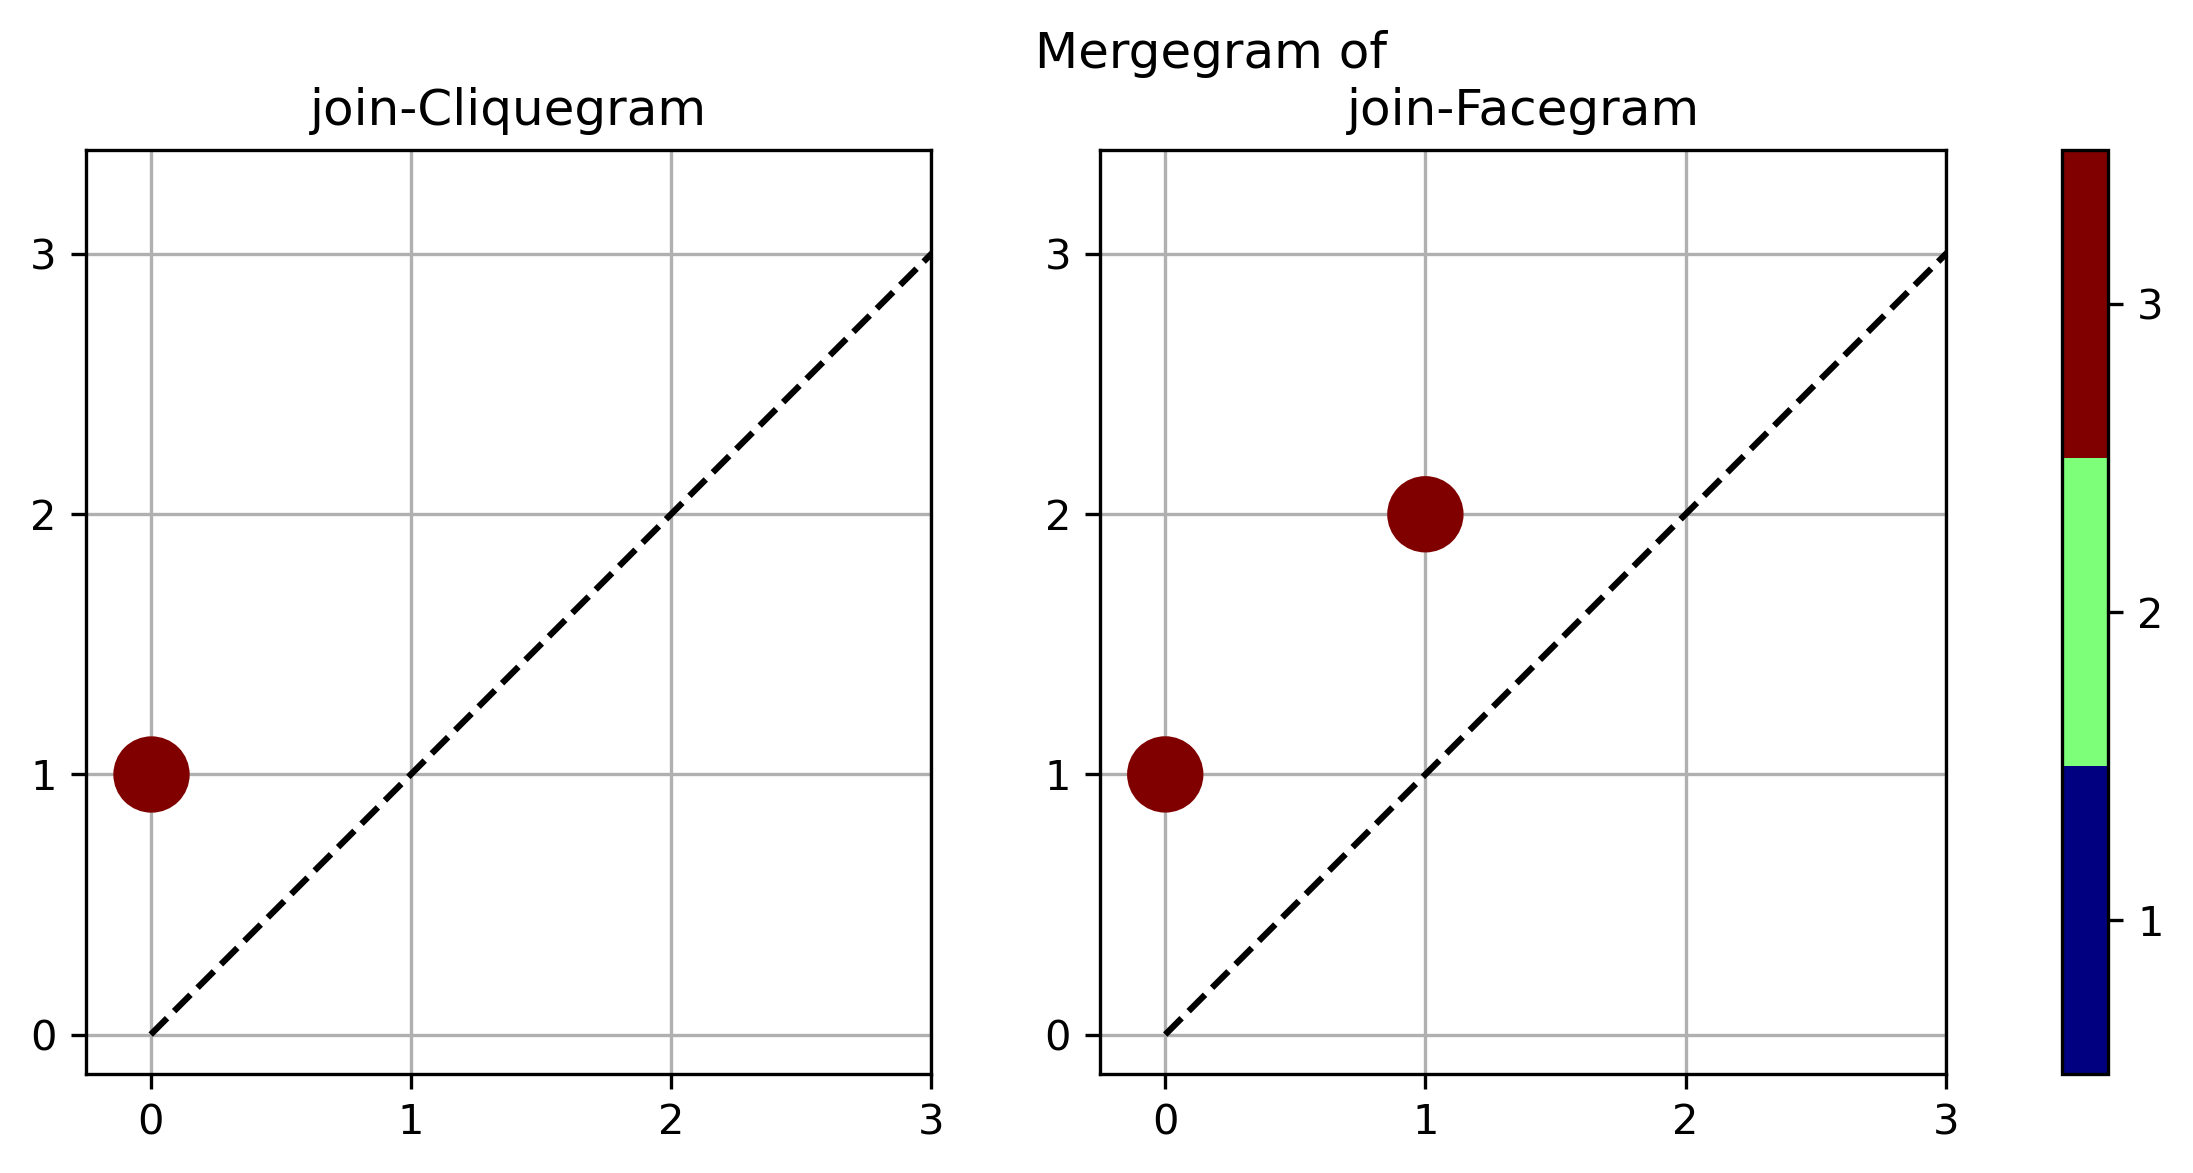

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=300)

for i, mgm in enumerate([mgm_clique, mgm_face]):
    points, counts = np.unique(mgm, return_counts=True, axis=0)
    im = ax[i].scatter(points[:,0], points[:,1], s=counts*100,
                       c=counts, cmap='jet', vmin=1, vmax=3)

    cmap = plt.cm.jet  
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (.5, .5, .5, 1.0)
    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
    # define the bins and normalize
    bounds = [0.5, 1.5, 2.5, 3.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for i in range(2):
    ax[i].plot([0, 4], [0, 4], 'k--')
    ax[i].axis('equal')
    # ax[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    # ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i].set_xlim(-0.25, 3)
    ax[i].set_ylim(0, 3.25)
    ax[i].set_xticks([0, 1, 2, 3])
    ax[i].set_yticks([0, 1, 2, 3])

    ax[i].set_axisbelow(True)
    ax[i].grid(True)

ax[0].set_title('join-Cliquegram')
ax[1].set_title('join-Facegram')
fig.suptitle('Mergegram of')

fig.colorbar(im, ax=ax.ravel().tolist(),
        cmap=cmap, norm=norm,
        ticks=MaxNLocator(integer=True),
        boundaries=bounds, format='%1i')
fig.savefig(Path('plots', 'dataset2_Mergegrams_for_dendrograms.png'), dpi=300, bbox_inches='tight')

# Dataset 3: other example 3 treegrams


In [15]:
treedistances = []

dist = np.array([[0,10,10,10.5,12.5],
                 [0,0,2.5, 10.5,12.5],
                 [0,0,0,10.5,12.5],
                 [0,0,0,0,12.5],
                 [0,0,0,0,0]])
dist += np.transpose(dist)
treedistances.append(dist)

dist = np.array([[0,9,5,9,4],
                 [0,0,9,9,9],
                 [0,0,0,9,5],
                 [0,0,0,0,9],
                 [0,0,0,0,0]])
dist += np.transpose(dist)
treedistances.append(dist)

dist = np.array([[0,6,10,10,6],
                 [0,0,10,10,4],
                 [0,0,0,10,10],
                 [0,0,0,0,10],
                 [0,0,0,0,0]])
dist += np.transpose(dist)
treedistances.append(dist)

treegrams = Treegrams(treedistances=treedistances)
mgm_trees = treegrams.compute_labelled_mergegram()

cliquegram = Cliquegram()
cliquegram.minimizer_from_treegrams(treegrams.treedistances)
mgm_clique = cliquegram.compute_mergegram()

facegram = Facegram(treegrams=treegrams)
mgm_face = facegram.compute_join()

mgm_tree1 = format_mergegram(mgm_trees[0], delete_infinite=True)
mgm_tree2 = format_mergegram(mgm_trees[1], delete_infinite=True)
mgm_tree3 = format_mergegram(mgm_trees[2], delete_infinite=True)

mgm_clique = format_mergegram(mgm_clique, delete_infinite=True)
mgm_face = format_mergegram(mgm_face, delete_infinite=True)


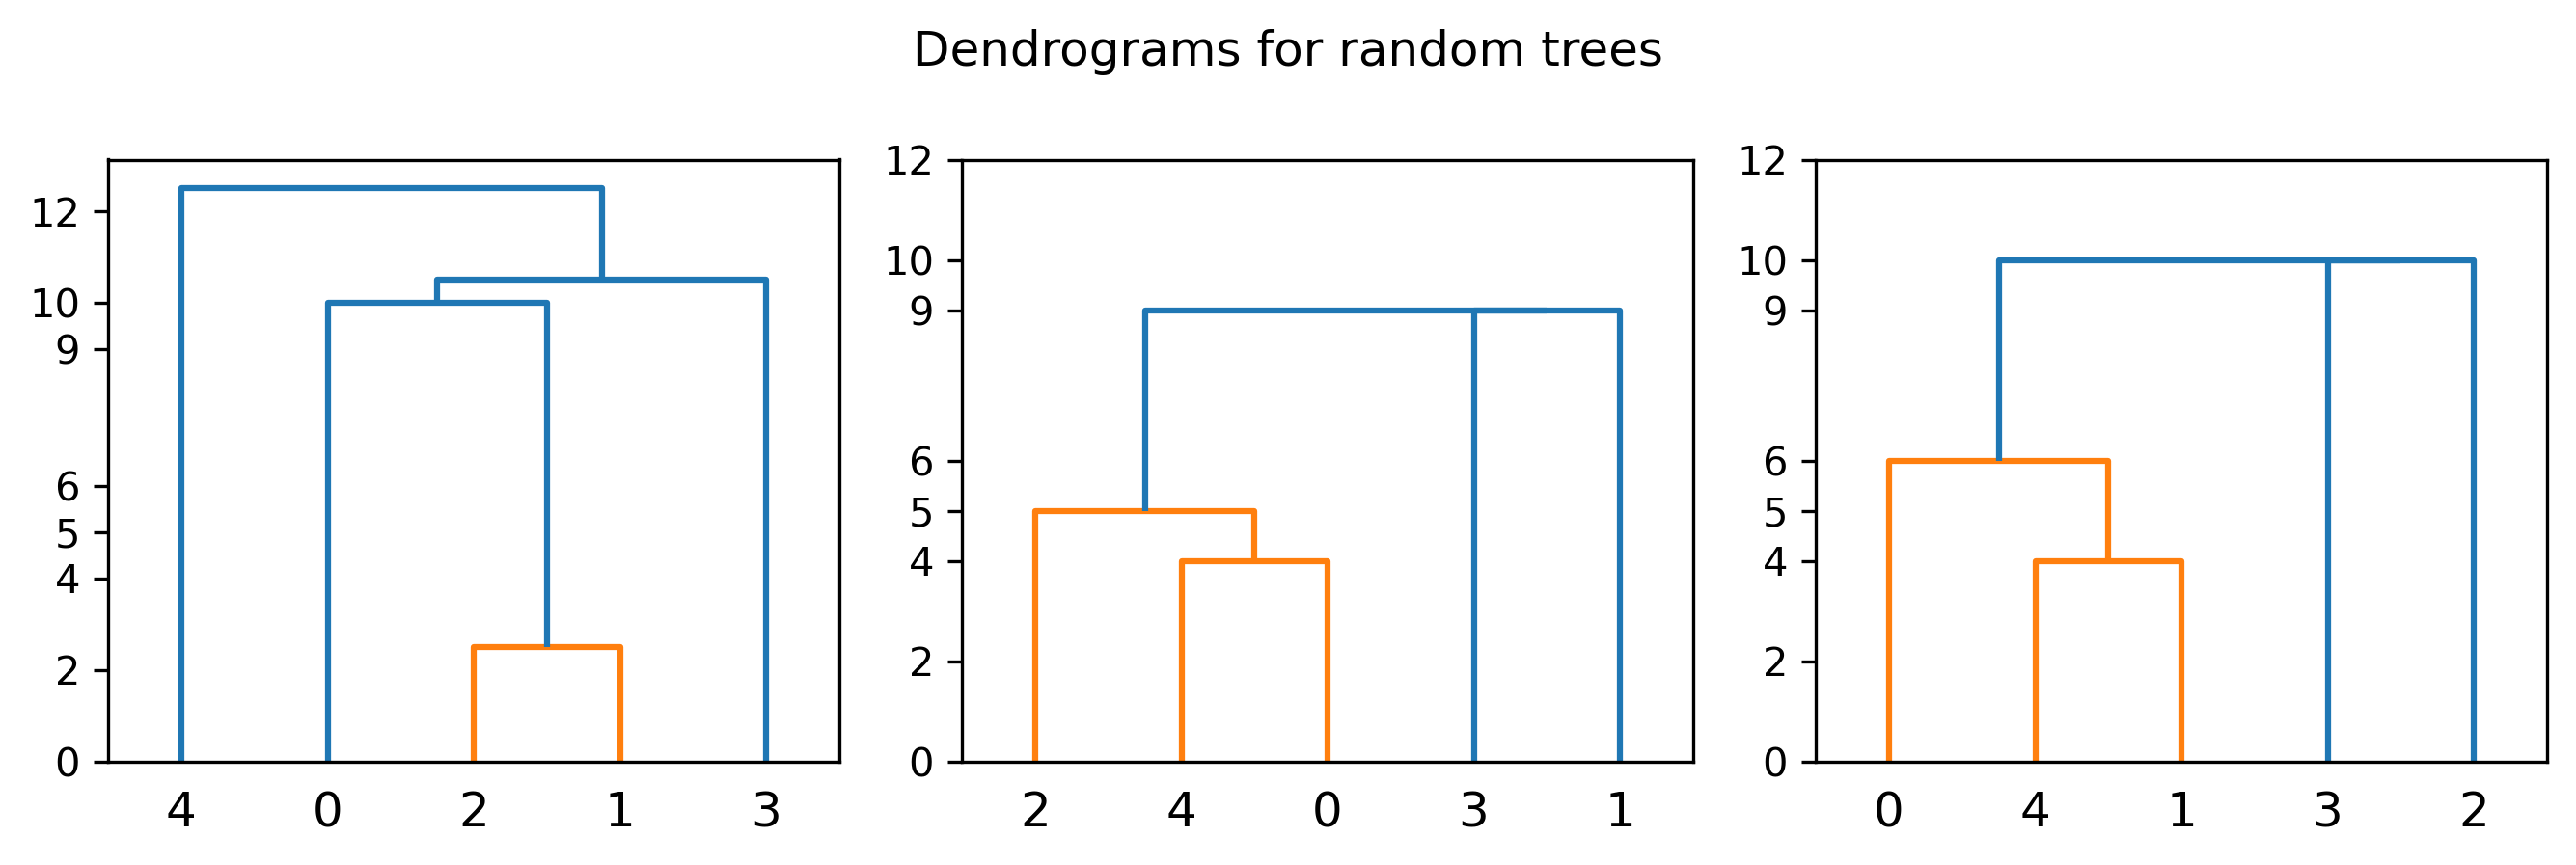

In [16]:
dendrograms = [sch.linkage(squareform(np.squeeze(td)),
              method='complete',
              metric='euclidean',
              optimal_ordering=True)
              for td in treedistances]

fig, ax = plt.subplots(1,3, figsize=(9,3), dpi=300)
for i in range(3):
    sch.dendrogram(dendrograms[i], ax=ax[i])
    ax[i].set_yticks([0,  2, 4, 5, 6, 9, 10, 12])
fig.suptitle('Dendrograms for random trees')
fig.tight_layout()
fig.savefig(Path('plots', 'dataset3_Dendrograms_3.png'), dpi=300, bbox_inches='tight')

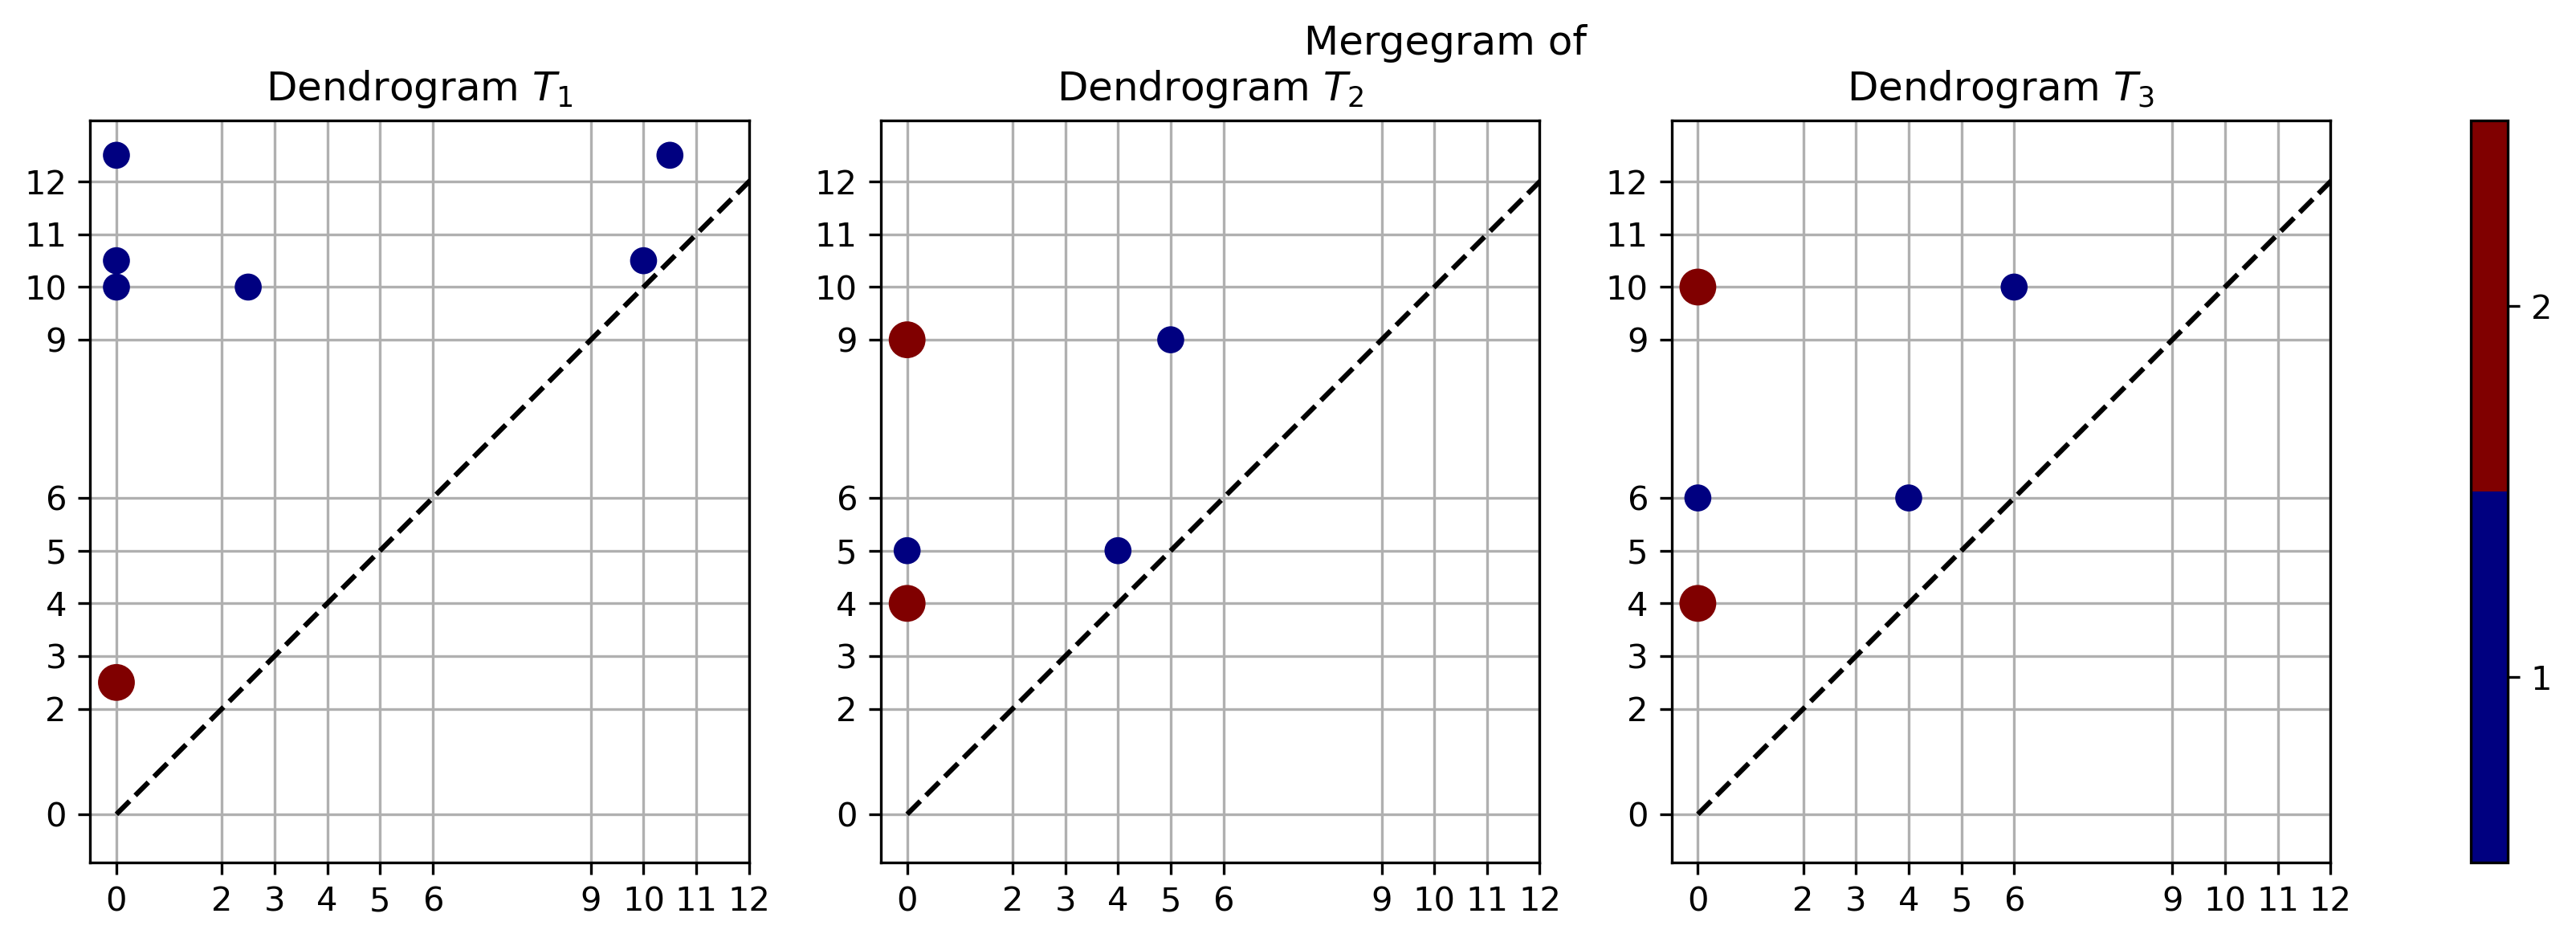

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=300)

for i, mgm in enumerate([mgm_tree1, mgm_tree2, mgm_tree3]):
    points, counts = np.unique(mgm, return_counts=True, axis=0)
    im = ax[i].scatter(points[:,0], points[:,1], s=counts*50,
                       c=counts, cmap='jet', vmin=1, vmax=2)

    cmap = plt.cm.jet  
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (.5, .5, .5, 1.0)
    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
    # define the bins and normalize
    bounds = [0.5, 1.5, 2.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for i in range(3):
    
    ax[i].plot([0, 13], [0, 13], 'k--')
    ax[i].axis('equal')
    # ax[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    # ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i].set_xlim(-0.5, 12)
    ax[i].set_ylim(0, 12.25)
    ax[i].set_xticks([0,2,3, 4, 5, 6, 9, 10, 11, 12])
    ax[i].set_yticks([0,2,3, 4, 5, 6, 9, 10, 11, 12])

    ax[i].set_axisbelow(True)
    ax[i].grid(True)

ax[0].set_title('Dendrogram $T_1$')
ax[1].set_title('Dendrogram $T_2$')
ax[2].set_title('Dendrogram $T_3$')
fig.suptitle('Mergegram of')

fig.colorbar(im, ax=ax.ravel().tolist(),
        cmap=cmap, norm=norm,
        ticks=MaxNLocator(integer=True),
        boundaries=bounds, format='%1i')
fig.savefig(Path('plots', 'dataset3_Mergegrams_for_dendrograms.png'), dpi=300, bbox_inches='tight')

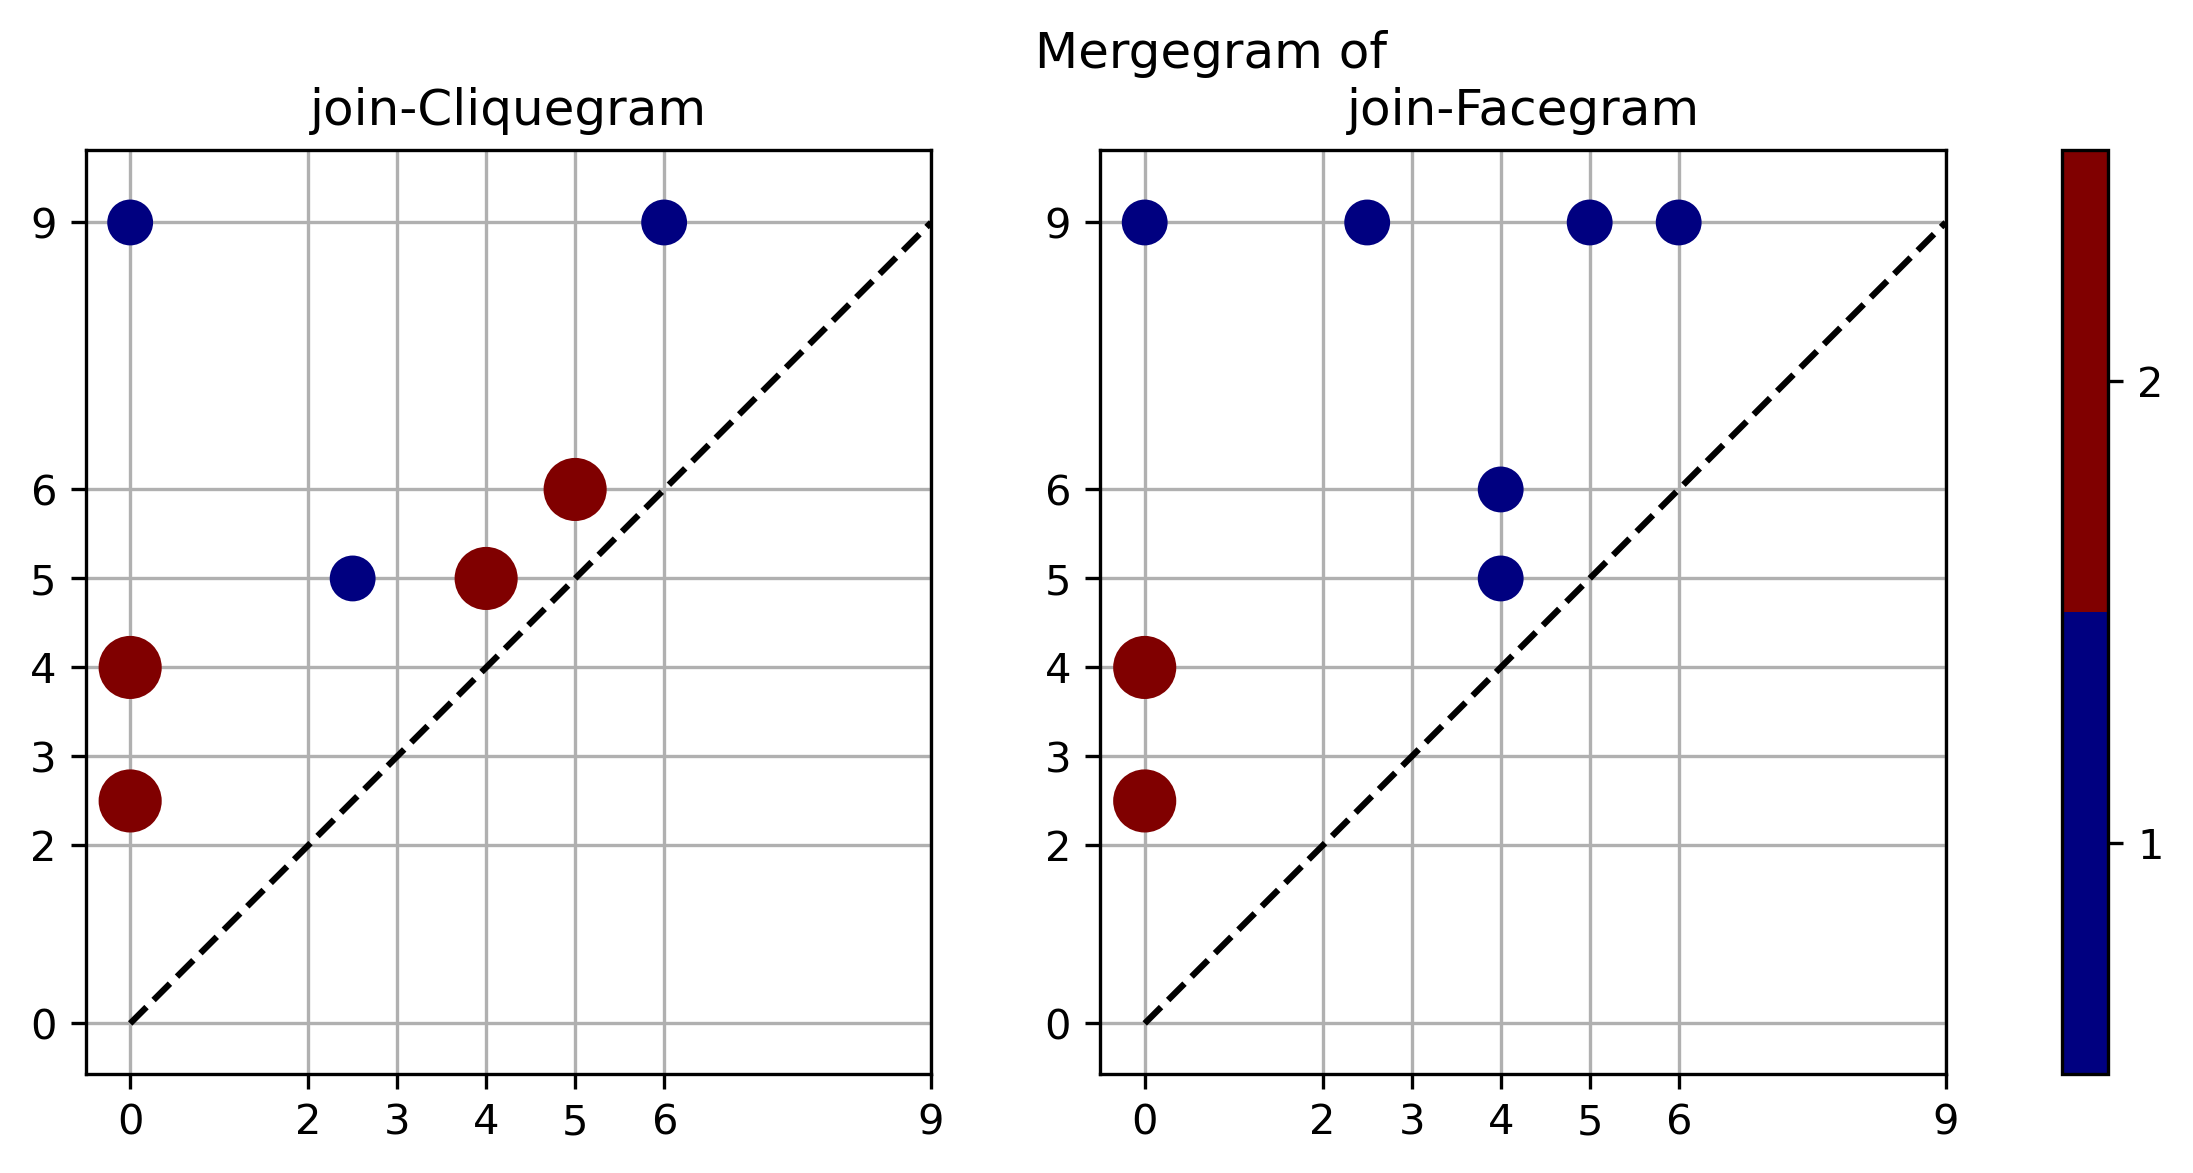

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=300)

for i, mgm in enumerate([mgm_clique, mgm_face]):
    points, counts = np.unique(mgm, return_counts=True, axis=0)
    im = ax[i].scatter(points[:,0], points[:,1], s=counts*100,
                       c=counts, cmap='jet', vmin=1, vmax=2)

    cmap = plt.cm.jet  
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (.5, .5, .5, 1.0)
    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
    # define the bins and normalize
    bounds = [0.5, 1.5, 2.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for i in range(2):
    ax[i].plot([0, 9], [0, 9], 'k--')
    ax[i].axis('equal')
    # ax[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    # ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i].set_xlim(-0.5, 9)
    ax[i].set_ylim(0, 9.25)
    ax[i].set_xticks([0,2,3, 4, 5, 6, 9])
    ax[i].set_yticks([0,2,3, 4, 5, 6, 9])

    ax[i].set_axisbelow(True)
    ax[i].grid(True)

ax[0].set_title('join-Cliquegram')
ax[1].set_title('join-Facegram')
fig.suptitle('Mergegram of')

fig.colorbar(im, ax=ax.ravel().tolist(),
        cmap=cmap, norm=norm,
        ticks=MaxNLocator(integer=True),
        boundaries=bounds, format='%1i')
fig.savefig(Path('plots', 'dataset3_Mergegrams_for_cliquegramfacegram.png'), dpi=300, bbox_inches='tight')

# Dataset 4: proper phylogenetic example

In [2]:
# read in all the matrices
treedistances = np.load(Path('data', 'ultramatrices_real.npz'))['treedistances']
leaves_names = np.load(Path('data', 'ultramatrices_real.npz'))['leaves_names']

In [6]:
leaves_names

array(['UMMZ_242601_De_tinc', 'WAMR168645', 'SAMAR29205',
       'UMMZ_244247_ne_levi', 'RAN_64845', 'SEW6684',
       'UMMZ_242646_Ct_quat', 'TJC564', 'UMMZ_237560', 'TMOTT241',
       'USNM576222', 'UMMZ_Bipes_canaliculatus', 'TJC811', 'MVZ247605',
       'CHUNB52077', 'CHUNB51969', 'AMSR122474', 'FMNH230175',
       'CHUNB37546', 'CHUNB47014', 'MVZ_Herp_240678', 'MVZ_Herp_196648',
       'CHUNB11470', 'CHUNB68997', 'CHUNB74034', 'MCZ_Herp_R189884',
       'MCZ_Herp_R190725', 'CHUNB62385', 'MVZ149849', 'CHUNB62191',
       'GRCOLLI23142', 'CHUNB57731', 'CAS_223962', 'MVZ_Herp_249821',
       'UMMZ_201904', 'MVZ_Herp_269290', 'CAS_232085', 'UMFS_10680',
       'FK_3102', 'UMMZ_227683', 'UMFS_11002', 'UMFS_5617', 'CHUNB73453',
       'UMMZ_229268', 'NTMR16167', 'UMFS_11534', 'UMFS_9997',
       'UMFS_10995', 'FK_3026', 'ID_7603', 'UMMZ_201900', 'RAP0448',
       'MVZ_Herp_204069', 'MCZ_Herp_R190692', 'UMMZ_240786', 'UMFS_10133',
       'CAS_234252', 'MVZ_Herp_257729', 'MVZ_Herp_177806'

In [20]:
treegrams = Treegrams(treedistances=treedistances)
mgm_trees = treegrams.compute_labelled_mergegram()

cliquegram = Cliquegram()
cliquegram.minimizer_from_treegrams(treegrams.treedistances)
mgm_clique = cliquegram.compute_mergegram()

facegram = Facegram(treegrams=treegrams)
mgm_face_lab = facegram.compute_join()

mgm_clique = format_mergegram(mgm_clique, delete_infinite=True)
mgm_face = format_mergegram(mgm_face_lab, delete_infinite=True)

In [21]:
mergegrams_treegrams = [format_mergegram(td, delete_infinite=True) for td in mgm_trees]

In [22]:
# there are only three points with a large persistence
# two are singleton clusters, one isn't
high_persistence = [[key, mgm_face_lab[key]] for key in mgm_face_lab if mgm_face_lab[key][1] - mgm_face_lab[key][0] > 1]
largecluster_highpersistence = high_persistence[2][0]

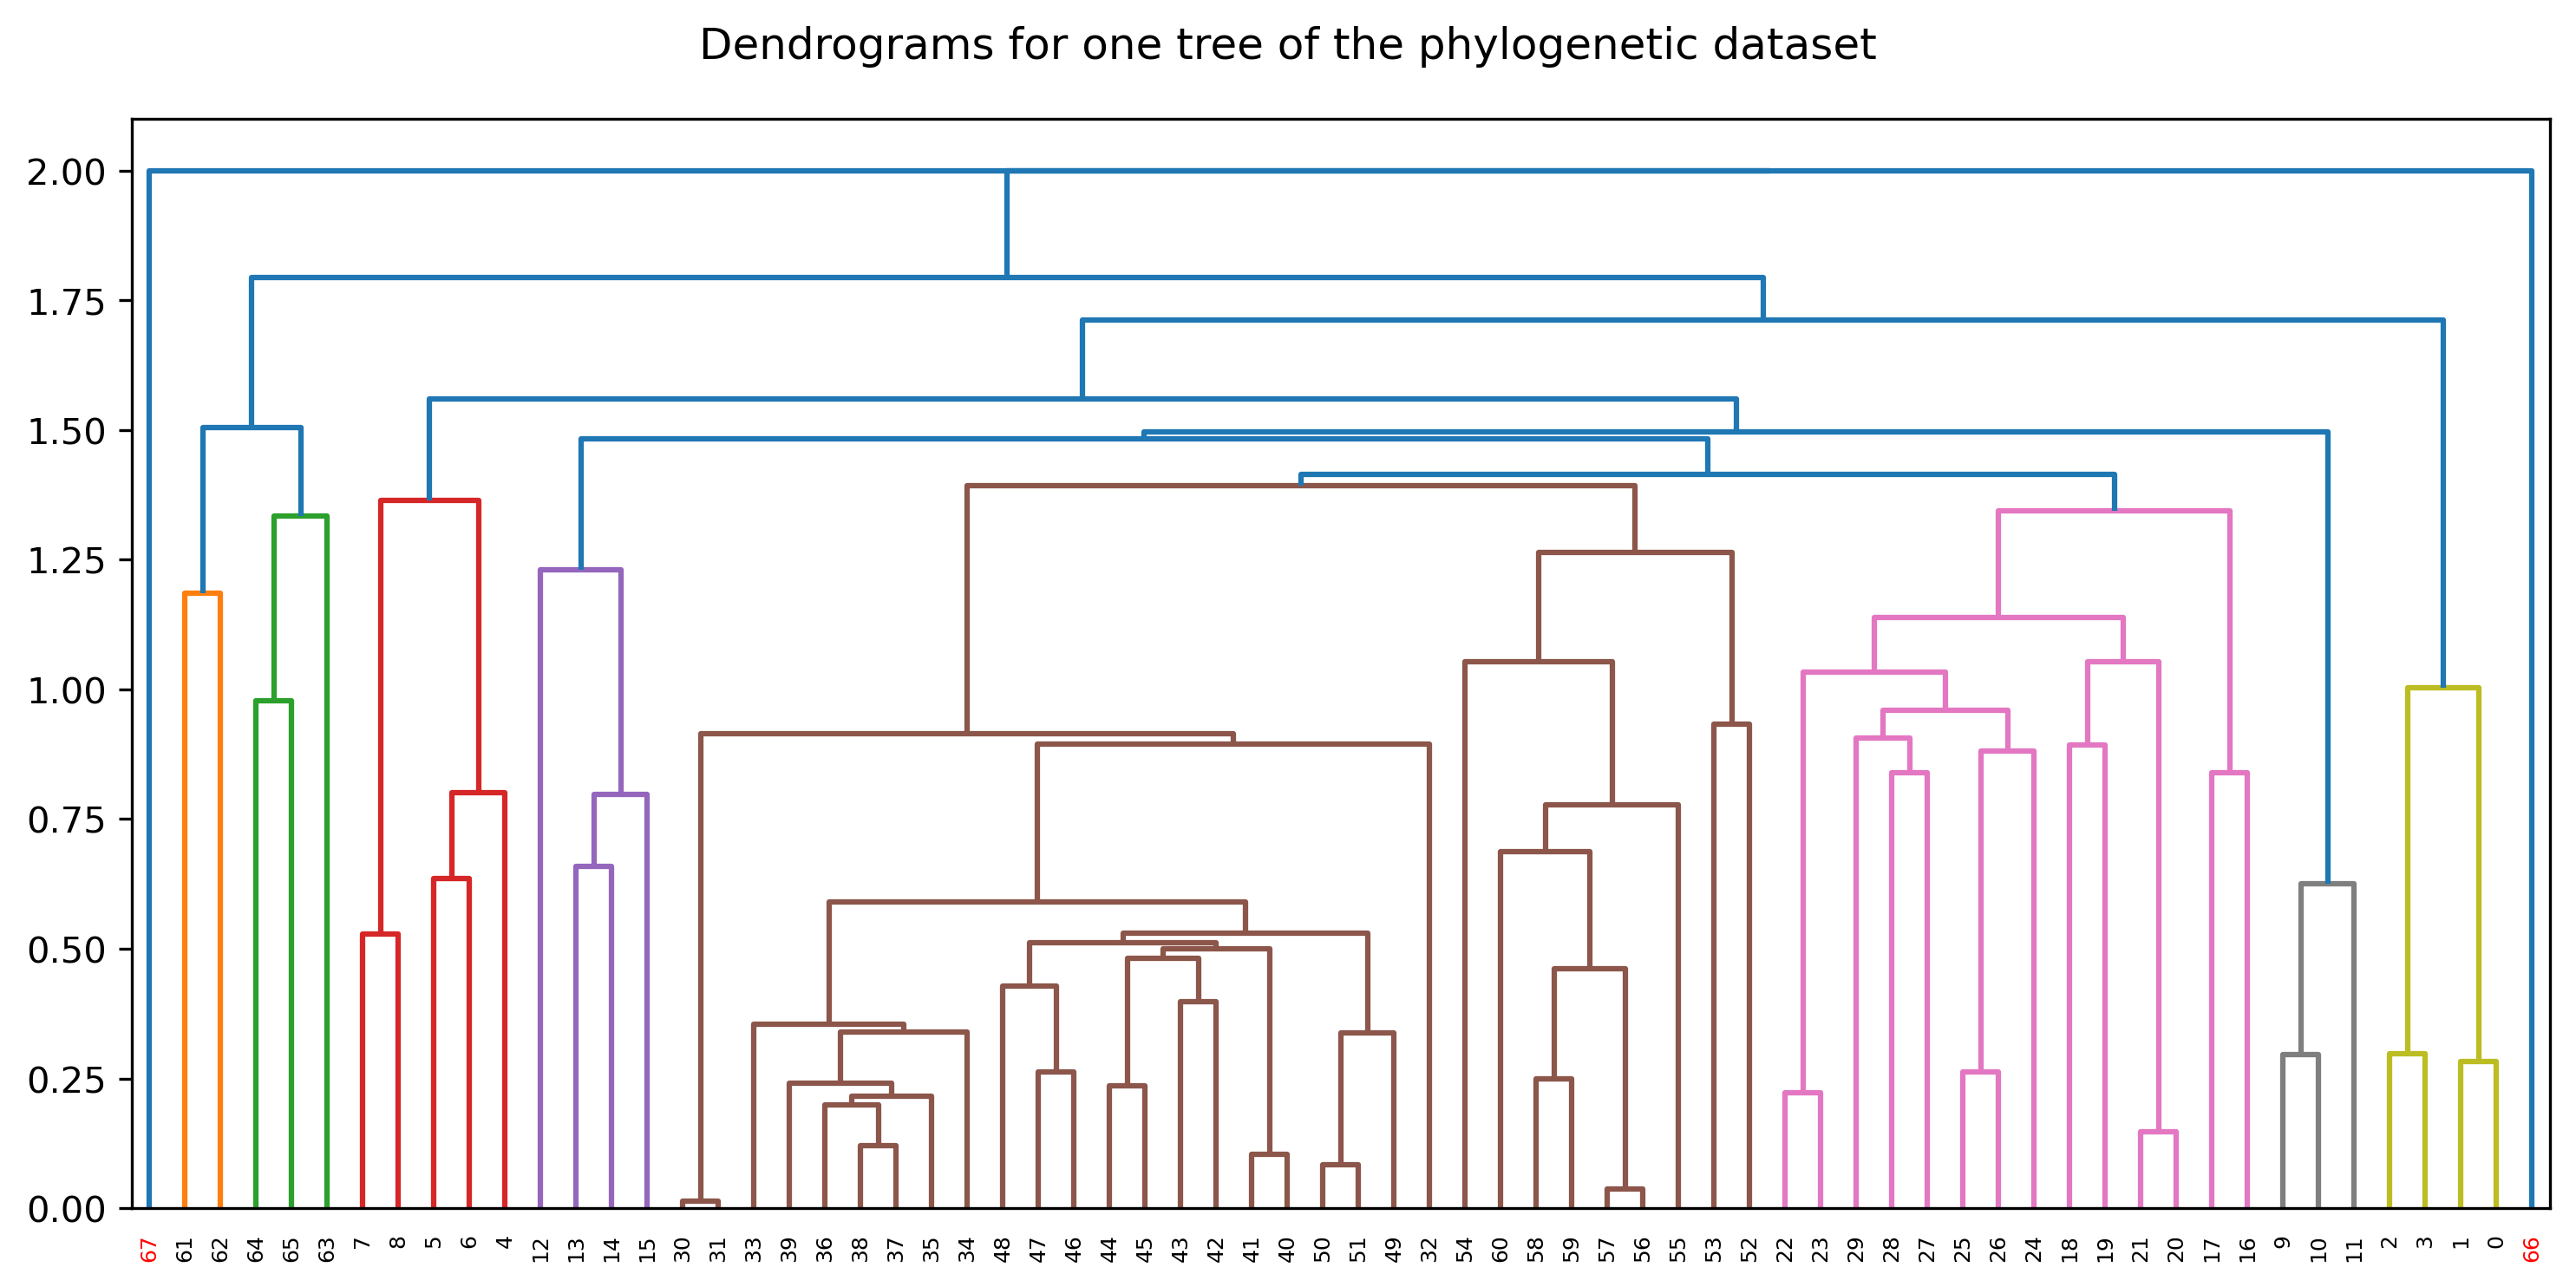

In [23]:
dendrograms = [sch.linkage(squareform(np.squeeze(td)),
              method='complete',
              metric='euclidean',
              optimal_ordering=True)
              for td in treedistances[:2]]

# fig, ax = plt.subplots(2,1, figsize=(10, 10), dpi=300)
# for i in range(2):
#     sch.dendrogram(dendrograms[i], ax=ax[i])
#     for tt in [tt for tt in ax[i].get_xticklabels() if int(tt.get_text()) not in largecluster_highpersistence]:
#         tt.set_color('red')
fig, ax = plt.subplots(1,1, figsize=(10, 5), dpi=300)
sch.dendrogram(dendrograms[0], ax=ax)
for tt in [tt for tt in ax.get_xticklabels() if int(tt.get_text()) not in largecluster_highpersistence]:
    tt.set_color('red')
fig.suptitle('Dendrograms for one tree of the phylogenetic dataset')
fig.tight_layout()
fig.savefig(Path('plots', 'dataset4_Dendrograms_3.png'), dpi=300, bbox_inches='tight')

In [24]:
# mgm_face = mgm_face[mgm_face[:,1] - mgm_face[:,0] < 1, :]
# mgm_clique = mgm_clique[mgm_clique[:,1] - mgm_clique[:,0] < 1, :]

In [25]:
pt_face, count_face = np.unique(mgm_face, return_counts=True, axis=0)
pt_clique, count_clique = np.unique(mgm_clique, return_counts=True, axis=0)

print('Points in the join-mergegram of facegram but not the cliquegram:',
      len(set([tuple(x) for x in pt_face]).difference(set([tuple(x) for x in pt_clique]))))
print('Points in the join-mergegram of cliquegram but not the facegram:',
      len(set([tuple(x) for x in pt_clique]).difference(set([tuple(x) for x in pt_face]))))

print('Their persistence is:')
for point in set([tuple(x) for x in pt_clique]).difference(set([tuple(x) for x in pt_face])):
    print('  ', point[1] - point[0])

print('Count differences of points in both mergegrams?:')
for pt_same in set([tuple(x) for x in pt_face]).intersection(set([tuple(x) for x in pt_clique])):
    idx_clique = np.where(np.all(pt_clique == pt_same, axis=1))[0]
    idx_face = np.where(np.all(pt_face == pt_same, axis=1))[0]

    if count_face[idx_face] != count_clique[idx_clique]:
        print('  ', pt_same, count_face[idx_face], count_clique[idx_clique])

Points in the join-mergegram of facegram but not the cliquegram: 0
Points in the join-mergegram of cliquegram but not the facegram: 4
Their persistence is:
   9.992007221626409e-16
   9.71445146547012e-17
   9.992007221626409e-16
   9.71445146547012e-17
Count differences of points in both mergegrams?:


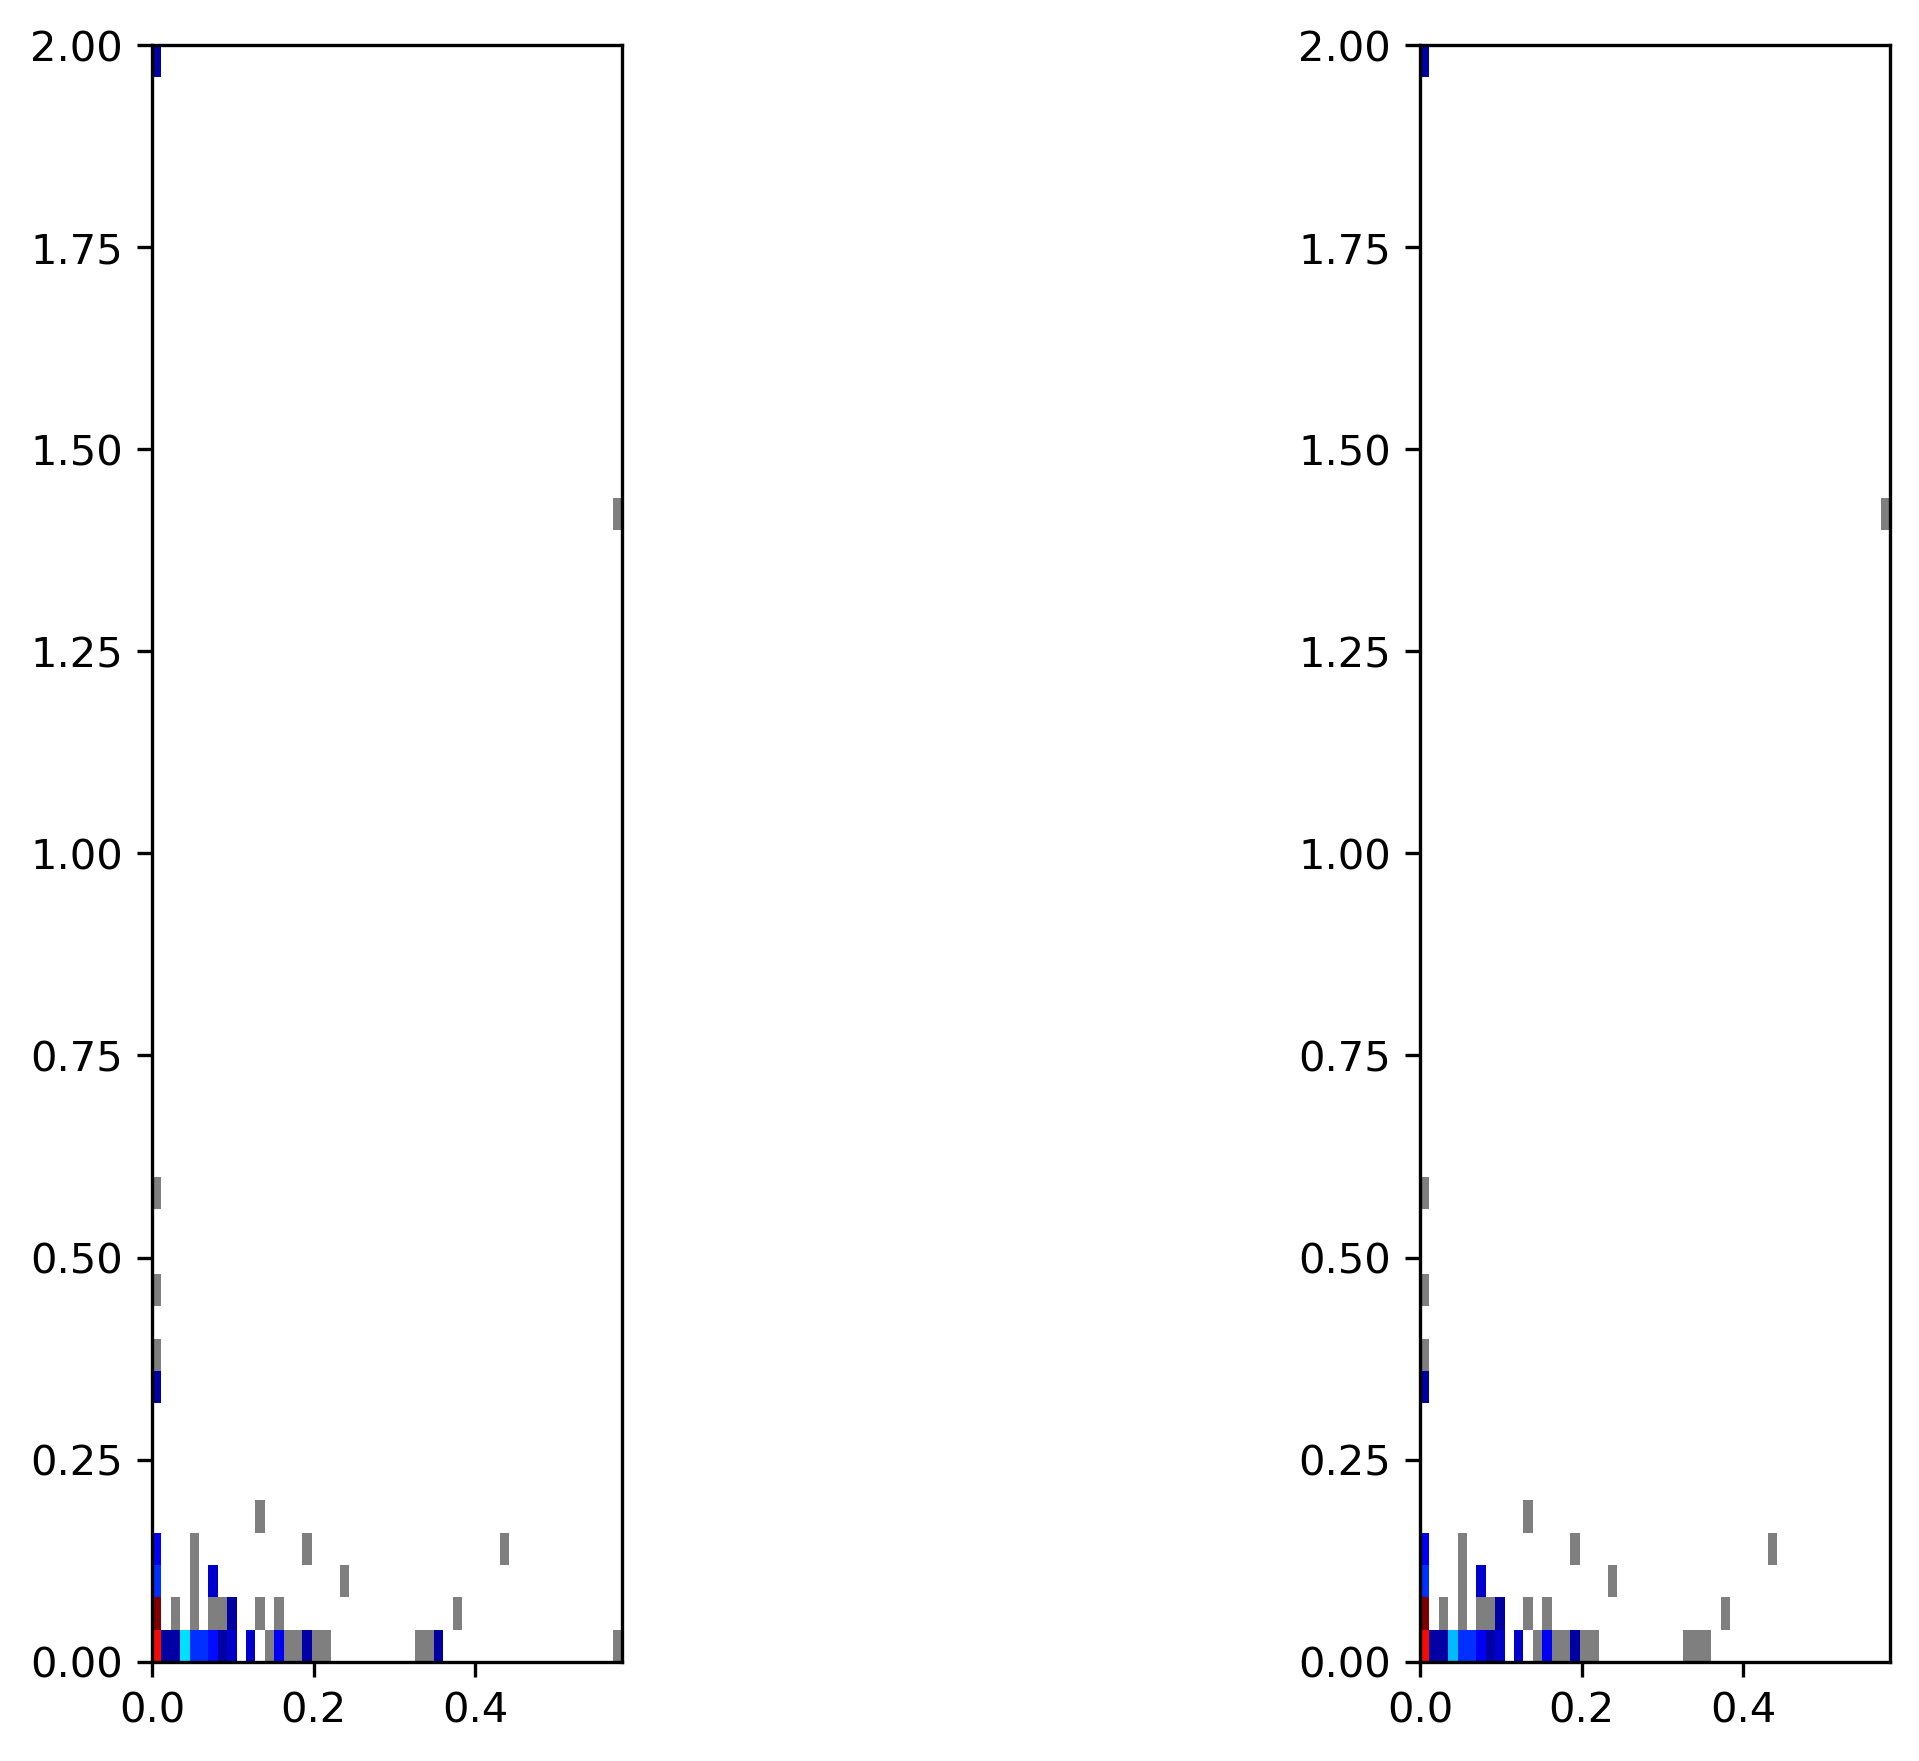

In [26]:


fig, ax = plt.subplots(1, 2, figsize=(10, 7), dpi=300)
counts, binx, biny = np.histogram2d(mgm_clique[:,0], mgm_clique[:,1]-mgm_clique[:,0], bins=[50, 50])
ax[0].imshow(np.ma.masked_array(counts.T, counts.T==0),
           origin='lower',
           extent=[binx[0], binx[-1], biny[0], biny[-1]],
           cmap=cmap)

counts, binx, biny = np.histogram2d(mgm_face[:,0], mgm_face[:,1]-mgm_face[:,0], bins=[binx, biny])
ax[1].imshow(np.ma.masked_array(counts.T, counts.T==0),
           origin='lower',
           extent=[binx[0], binx[-1], biny[0], biny[-1]],
           cmap=cmap)

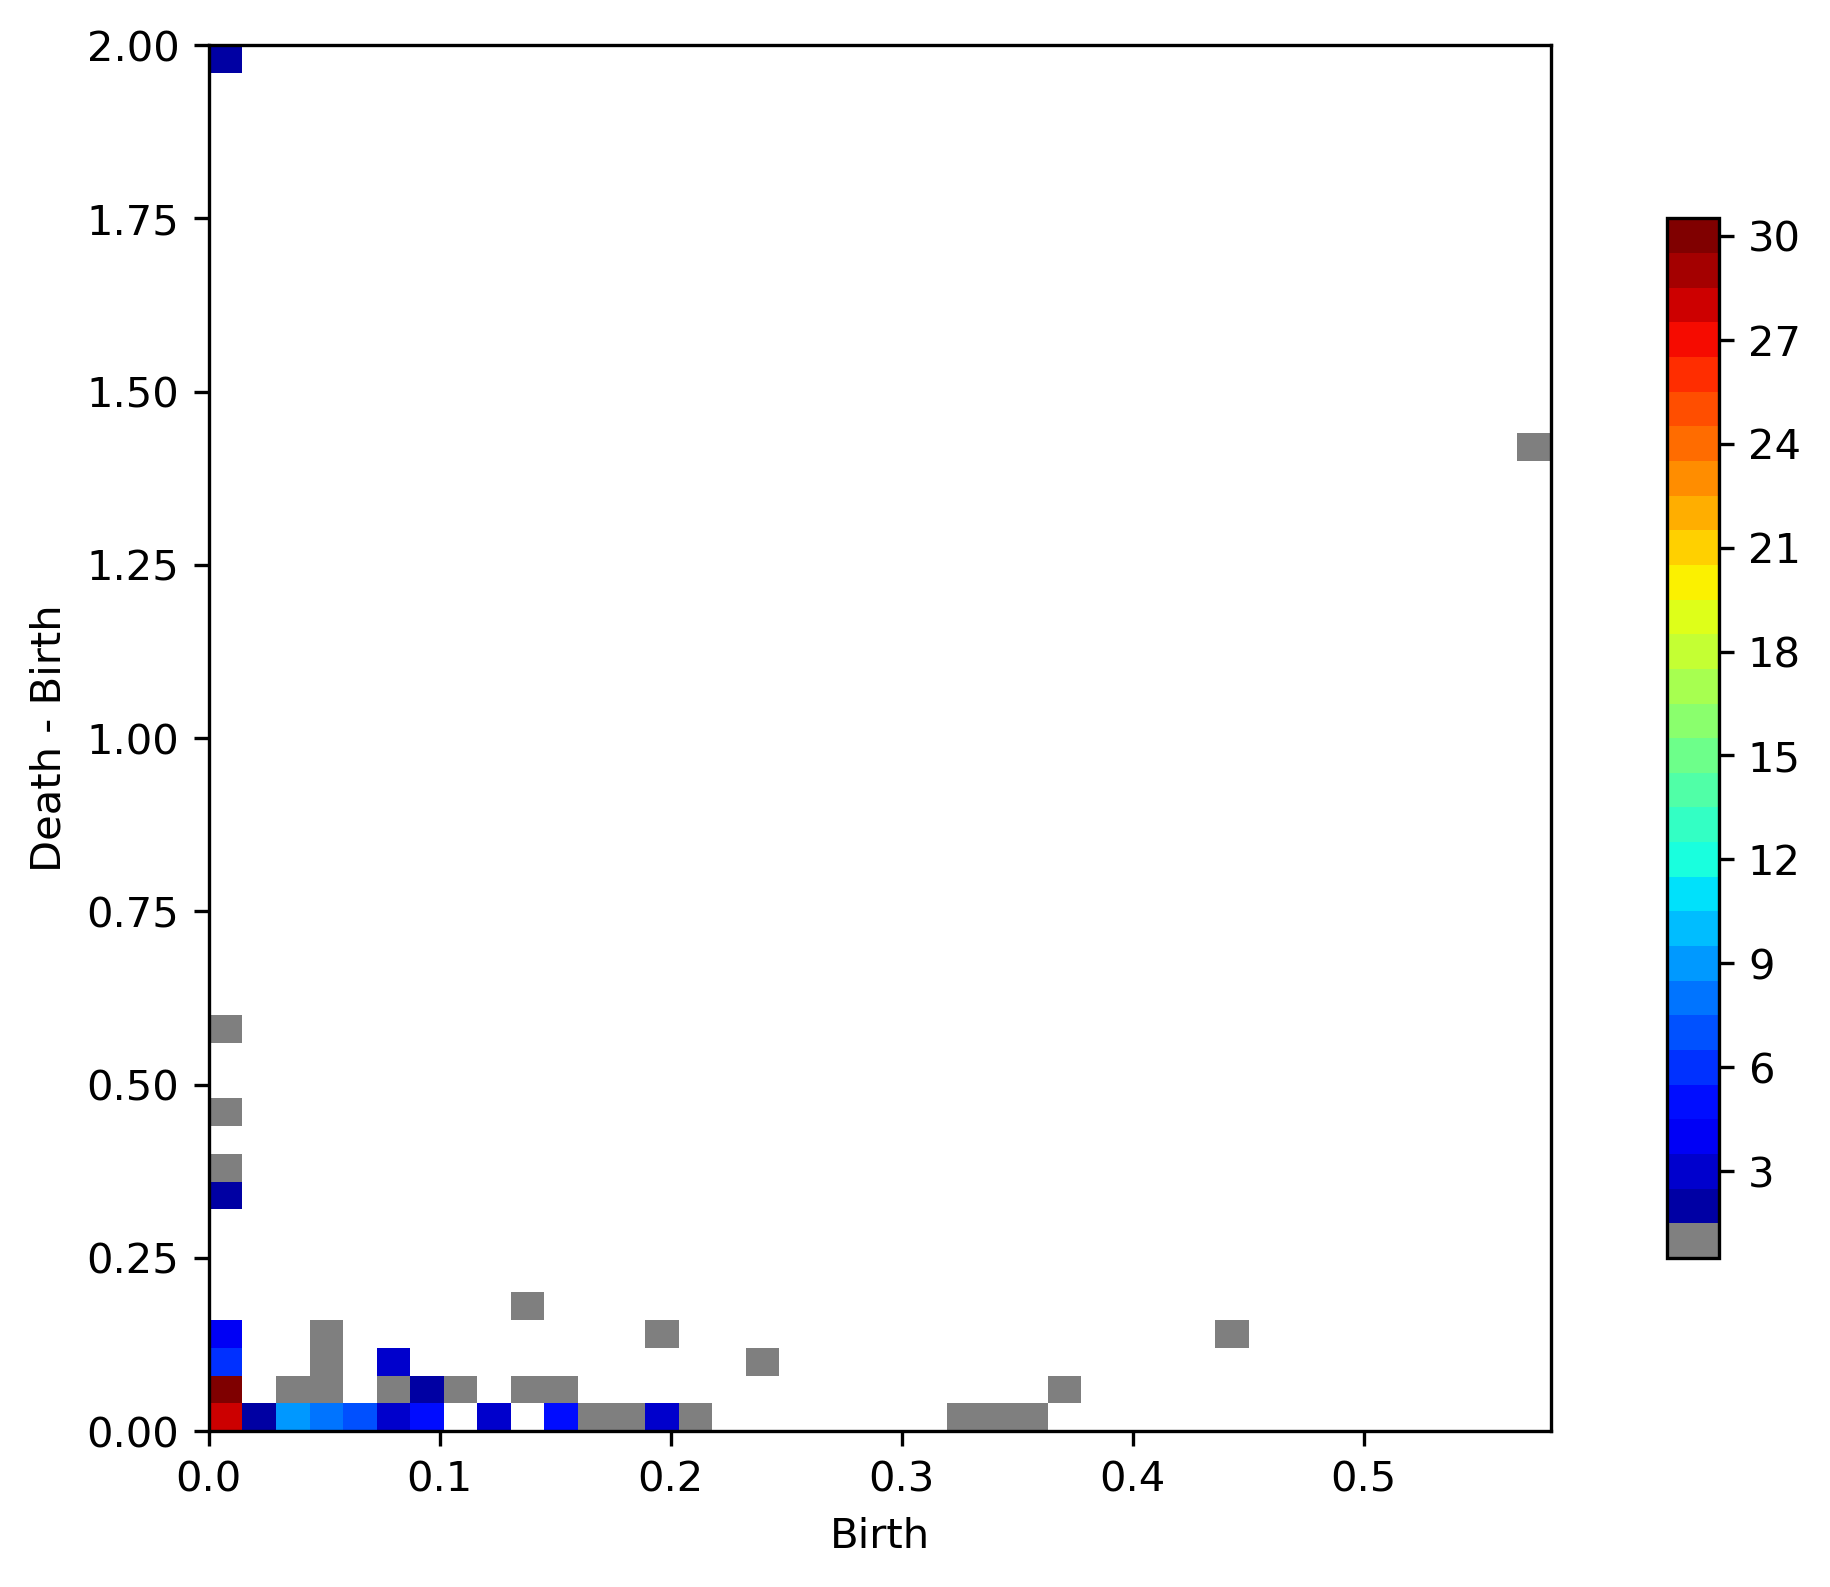

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10,6), 
                       dpi=300)

cmap = plt.cm.jet  
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5, .5, .5, 1.0)
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = [0.5 + i for i in range(1+int(np.ceil(np.max(counts))))]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

counts, binx, biny = np.histogram2d(mgm_face[:,0], mgm_face[:,1]-mgm_face[:,0], bins=[40,50])
im = ax.imshow(np.ma.masked_array(counts.T, counts.T==0),
           origin='lower',
           extent=[binx[0], binx[-1], biny[0], biny[-1]],
           aspect=0.3,
           cmap=cmap)
fig.colorbar(im, ax=ax,
        cmap=cmap, norm=norm,
        ticks=MaxNLocator(integer=True),
        boundaries=bounds, format='%1i',
        shrink=0.75)
# ax.set_title('2d Histogram plot of the Mergegram of the\njoin-Facegram of the 160 phylogenetic trees')
ax.set_xlabel('Birth')
ax.set_ylabel('Death - Birth')

## BE AWARE THAT WE EXCLUDED THE OUTLIER POINT 63, 64!
fig.savefig(Path('plots', 'dataset4_Mergegram_facegram.png'), dpi=300, bbox_inches='tight')